In [82]:
import pickle

import numpy as np
import random
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.metrics.cluster import completeness_score, homogeneity_score
from scipy.stats import bootstrap, ttest_rel
from sklearn.metrics import adjusted_rand_score, silhouette_score

from utils import stats

### Load data

In [83]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.RandomState(RANDOM_SEED)

sns.set_theme("paper")
sns.set_context("talk")

In [84]:
with open("pickles_and_csvs/cluster_labels_embeddings_and_nn_graphs_95.pkl", "rb") as file:
    clusters_dict_l2_95 = pickle.load(file)
    clusters_dict_l2_95["n"] = 95
    clusters_dict_l2_95["distance_metric"] = "l2"
    clusters_dict_l2_95["alarm"] = "yes"

with open("pickles_and_csvs/cluster_labels_embeddings_and_nn_graphs_L1_95.pkl", "rb") as file:
    clusters_dict_l1_95 = pickle.load(file)
    clusters_dict_l1_95["n"] = 95
    clusters_dict_l1_95["distance_metric"] = "l1"
    clusters_dict_l1_95["alarm"] = "yes"

with open("pickles_and_csvs/cluster_labels_embeddings_and_nn_graphs_200.pkl", "rb") as file:
    clusters_dict_l2_200 = pickle.load(file)
    clusters_dict_l2_200["n"] = 200
    clusters_dict_l2_200["distance_metric"] = "l2"
    clusters_dict_l2_200["alarm"] = "yes"

with open("pickles_and_csvs/cluster_labels_embeddings_and_nn_graphs_500.pkl", "rb") as file:
    clusters_dict_l2_500 = pickle.load(file)
    clusters_dict_l2_500["n"] = 500
    clusters_dict_l2_500["distance_metric"] = "l2"
    clusters_dict_l2_500["alarm"] = "yes"

with open("pickles_and_csvs/cluster_labels_embeddings_and_nn_graphs_500_wo_alarm.pkl", "rb") as file:
    clusters_dict_l2_500_no_alarm = pickle.load(file)
    clusters_dict_l2_500_no_alarm["n"] = 500
    clusters_dict_l2_500_no_alarm["distance_metric"] = "l2"
    clusters_dict_l2_500_no_alarm["alarm"] = "no"

Wed Feb 12 16:06:45 2025 Building and compiling search function
Wed Feb 12 16:06:47 2025 Building and compiling search function
Wed Feb 12 16:06:50 2025 Building and compiling search function
Wed Feb 12 16:06:52 2025 Building and compiling search function
Wed Feb 12 16:06:53 2025 Building and compiling search function
Wed Feb 12 16:06:55 2025 Building and compiling search function
Wed Feb 12 16:06:57 2025 Building and compiling search function
Wed Feb 12 16:06:59 2025 Building and compiling search function
Wed Feb 12 16:07:01 2025 Building and compiling search function
Wed Feb 12 16:07:02 2025 Building and compiling search function
Wed Feb 12 16:07:04 2025 Building and compiling search function
Wed Feb 12 16:07:06 2025 Building and compiling search function
Wed Feb 12 16:07:08 2025 Building and compiling search function
Wed Feb 12 16:07:10 2025 Building and compiling search function
Wed Feb 12 16:07:12 2025 Building and compiling search function
Wed Feb 12 16:07:14 2025 Building and co

In [85]:
representation_keys = ["PAFs", "LFCCs", "Spectrograms", "VAE representations"]
algorithm_keys = ["kMeans", "kMeans-preset", "HDBSCAN", "Leiden", "Leiden_preset"]
dicts = [clusters_dict_l2_95, clusters_dict_l1_95, clusters_dict_l2_200, clusters_dict_l2_500, clusters_dict_l2_500_no_alarm]

##### Hopkins statistic

In [86]:
rows = []
for di in dicts:
    for representation in representation_keys:
        rows.append([di["n"], di["distance_metric"], di["alarm"], representation, stats.hopkins(di[representation]["embeddings"], RANDOM_SEED)])

hopkins_results = pd.DataFrame(
    rows, 
    columns=["N subsets", "Distance metric", "Alarm call subset", "Representation", "Hopkins"]
)

hopkins_results

,N subsets,Distance metric,Alarm call subset,Representation,Hopkins
0,95,l2,yes,PAFs,0.930656
1,95,l2,yes,LFCCs,0.984544
2,95,l2,yes,Spectrograms,0.879741
3,95,l2,yes,VAE representations,0.944052
4,95,l1,yes,PAFs,0.911853
5,95,l1,yes,LFCCs,0.967912
6,95,l1,yes,Spectrograms,0.876516
7,95,l1,yes,VAE representations,0.927955
8,200,l2,yes,PAFs,0.920632
9,200,l2,yes,LFCCs,0.977769


/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_92165/1200136567.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hopkins_filtered = hopkins_filtered[hopkins_results["Alarm call subset"] != "no"]


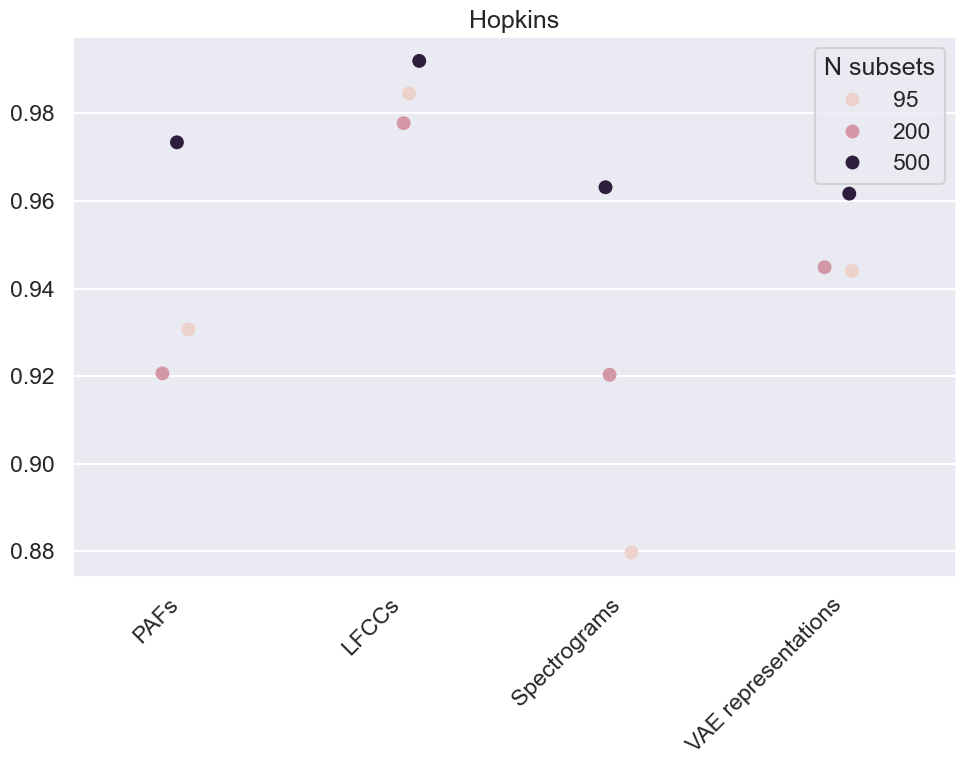

In [87]:
fig, ax = plt.subplots(figsize=(10, 8))
hopkins_filtered = hopkins_results[hopkins_results["Distance metric"] != "l1"]
hopkins_filtered = hopkins_filtered[hopkins_results["Alarm call subset"] != "no"]

# Raw data points
sns.stripplot(
    x="Representation", 
    y="Hopkins", 
    data=hopkins_filtered,
    ax=ax, 
    jitter=True, 
    size=10, 
    hue="N subsets", 
    legend=True
)

ax.set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
ax.set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
ax.set_title("Hopkins")
ax.set_xlabel('')
ax.set_ylabel('')

plt.tight_layout()
plt.show()

##### Silhouette score and modularity

In [88]:
rows = []

for di in dicts:
    for representation in representation_keys:
        for algorithm in algorithm_keys:
            if algorithm in "Leiden_preset":
                rows.append([
                    di["n"], 
                    di["distance_metric"], 
                    di["alarm"], 
                    representation, 
                    algorithm, 
                    None, 
                    None, 
                    None, 
                    di[representation]["Modularity"]
                    ])
                continue
            krusk_res = stats.silhouette_against_chance(di[representation][algorithm], di[representation]["embeddings"])
            rows.append([
                di["n"], 
                di["distance_metric"], 
                di["alarm"],
                representation, 
                algorithm, 
                silhouette_score(di[representation]["embeddings"], di[representation][algorithm]),
                krusk_res.statistic,
                krusk_res.pvalue, 
                None
                ])

clusterability_results = pd.DataFrame(
    rows, 
    columns=["N subsets", "Distance metric", "Alarm call subset", "Representation", "Algorithm", "Silhouette Score", "Silhouette score - Kruskal statistic", "Silhouette score - Kruskal p-value", "Modularity"]
)

clusterability_results

,N subsets,Distance metric,Alarm call subset,Representation,Algorithm,Silhouette Score,Silhouette score - Kruskal statistic,Silhouette score - Kruskal p-value,Modularity
0,95,l2,yes,PAFs,kMeans,0.546160,844.188924,1.333250e-185,NaN
1,95,l2,yes,PAFs,kMeans-preset,0.545690,847.330526,2.766411e-186,NaN
2,95,l2,yes,PAFs,HDBSCAN,0.464212,674.921008,8.500370e-149,NaN
3,95,l2,yes,PAFs,Leiden,NaN,NaN,NaN,0.706141
4,95,l2,yes,PAFs,Leiden_preset,NaN,NaN,NaN,0.706141
...,...,...,...,...,...,...,...,...,...
95,500,l2,no,VAE representations,kMeans,0.729418,3712.990349,0.000000e+00,NaN
96,500,l2,no,VAE representations,kMeans-preset,0.443599,3601.936560,0.000000e+00,NaN
97,500,l2,no,VAE representations,HDBSCAN,0.720531,3720.750151,0.000000e+00,NaN
98,500,l2,no,VAE representations,Leiden,NaN,NaN,NaN,0.729196


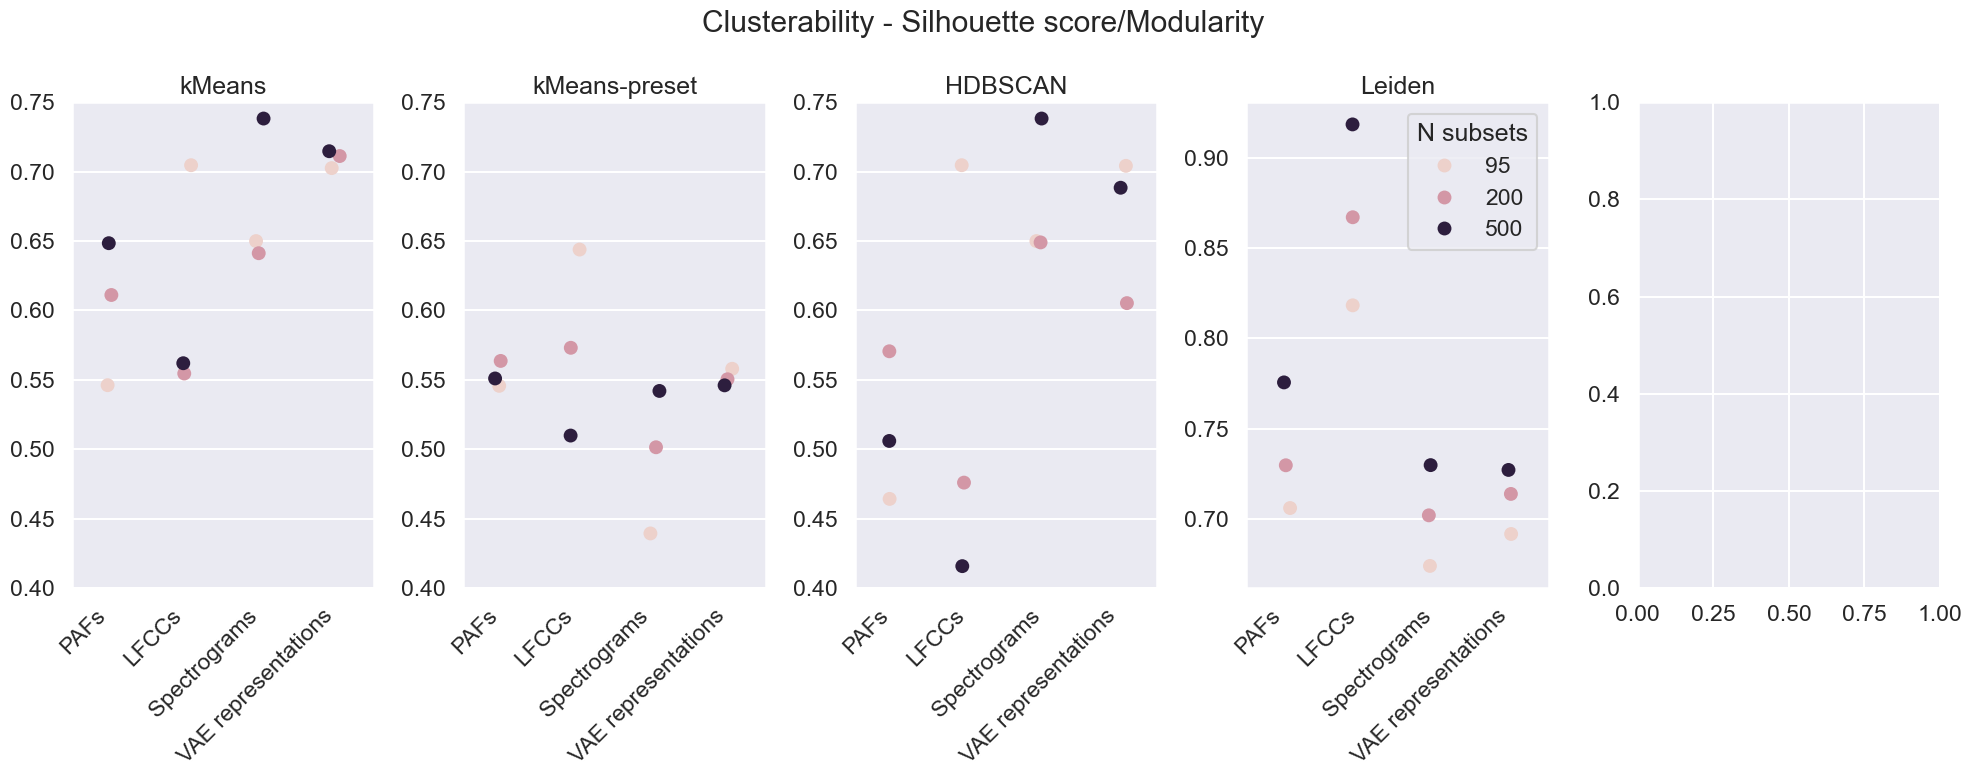

In [89]:
clusterability_results_filtered = clusterability_results[clusterability_results["Alarm call subset"]=="yes"]
clusterability_results_filtered = clusterability_results_filtered[clusterability_results_filtered["Distance metric"]=="l2"]
fig, axs = plt.subplots(ncols=5, figsize=(20, 8))

columns = ["kMeans", "kMeans-preset", "HDBSCAN", "Leiden"]
for i, column in enumerate(columns):
    # Raw data points
    sns.stripplot(
        x="Representation", 
        y="Silhouette Score" if column!= "Leiden" else "Modularity", 
        data=clusterability_results_filtered[clusterability_results_filtered["Algorithm"]==column], 
        ax=axs[i], 
        jitter=True, 
        size=10, 
        hue="N subsets", 
        legend=(True if i == len(columns)-1 else False)
    )
    # # Mean points
    # sns.pointplot(
    #     x="Representation", 
    #     y=column, 
    #     data=clusterability_results, 
    #     ax=axs[i], 
    #     errorbar=None,
    #     markers="o", 
    #     color="grey",
    #     alpha=0.3
    # )

    if column!= "Leiden":
        axs[i].set_ylim(.4,.75)
    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

fig.suptitle("Clusterability - Silhouette score/Modularity")
plt.tight_layout()
plt.show()

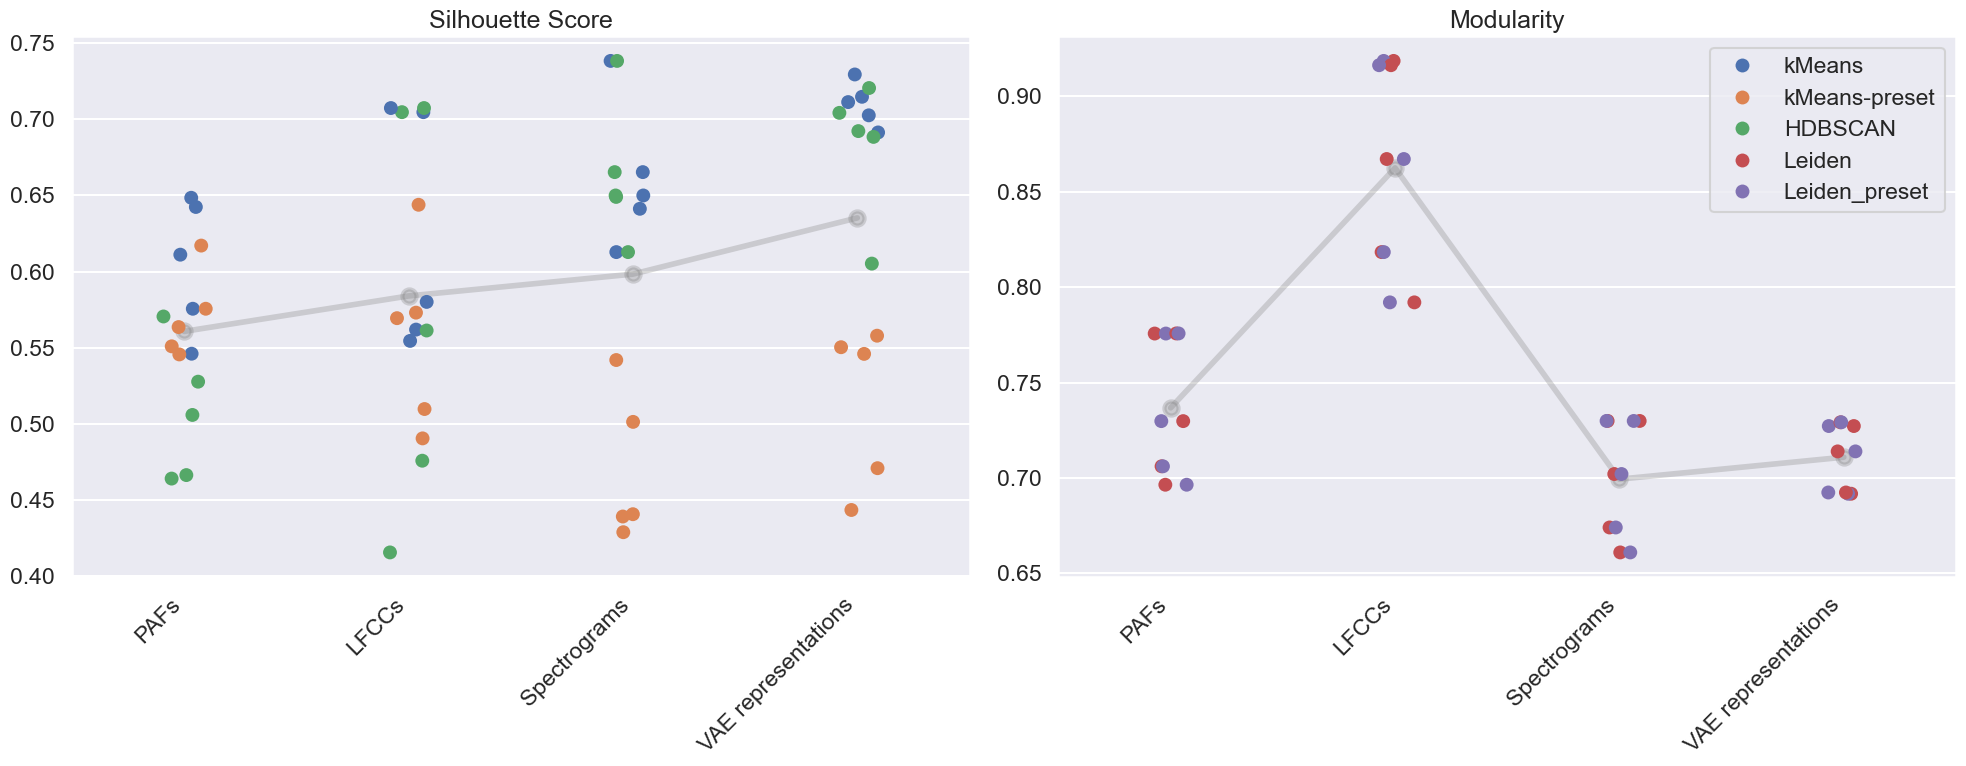

In [90]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

columns = ["Silhouette Score", "Modularity"]
for i, column in enumerate(columns):
    # Raw data points
    sns.stripplot(
        x="Representation", 
        y=column, 
        data=clusterability_results, 
        ax=axs[i], 
        jitter=True, 
        size=10, 
        hue="Algorithm", 
        legend=(True if i == len(columns)-1 else False)
    )
    # Mean points
    sns.pointplot(
        x="Representation", 
        y=column, 
        data=clusterability_results, 
        ax=axs[i], 
        errorbar=None,
        markers="o", 
        color="grey",
        alpha=0.3
    )

    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

plt.tight_layout()
plt.show()

##### True labels vs predicted labels

In [91]:
rows = []
for di in dicts:
    for representation in representation_keys:
        for algorithm in algorithm_keys:
            try:
                _, _, _, _, p_value, chance_level, distribution = stats.v_measure_against_chance(
                    di["true_labels"], 
                    di[representation][algorithm], 
                    n_permutations=100, 
                    plot=False)
            
                rows.append([
                    di["n"], 
                    di["distance_metric"], 
                    di["alarm"],
                    representation,
                    algorithm,
                    p_value,
                    chance_level, 
                    distribution,
                    bootstrap((di["true_labels"], di[representation][algorithm]), homogeneity_score, n_resamples=100, paired=True).bootstrap_distribution,
                    bootstrap((di["true_labels"], di[representation][algorithm]), completeness_score, n_resamples=100, paired=True).bootstrap_distribution,
                    bootstrap((di["true_labels"], di[representation][algorithm]), adjusted_rand_score, n_resamples=100, paired=True).bootstrap_distribution
                ])
            except:
                continue

true_vs_pred_df = pd.DataFrame(
    rows, 
    columns=["N subsets", "Distance metric", "Alarm call subset", "Representation", "Algorithm", "p-value", "Chance level", "V measure", "Homogeneity", "Completeness", "Adj. RS"]
)

In [92]:
true_vs_pred_df[true_vs_pred_df["Algorithm"]=="Leiden_preset"]

,N subsets,Distance metric,Alarm call subset,Representation,Algorithm,p-value,Chance level,V measure,Homogeneity,Completeness,Adj. RS
4,95,l2,yes,PAFs,Leiden_preset,0.0,0.012491,"[0.552248290206869, 0.5587747261863236, 0.6055...","[0.58094985802034, 0.6375683686604836, 0.58278...","[0.5822020237666896, 0.623030728877712, 0.6141...","[0.5348635361510817, 0.4994026790421725, 0.510..."
9,95,l2,yes,LFCCs,Leiden_preset,0.0,0.013291,"[0.41156015497840837, 0.41135250786151667, 0.4...","[0.4212167248690454, 0.47455277313424316, 0.39...","[0.47663301129497626, 0.4913550588571765, 0.47...","[0.27360663841704375, 0.2964909176790856, 0.28..."
14,95,l2,yes,Spectrograms,Leiden_preset,0.0,0.013196,"[0.44264596051746413, 0.4434126569145734, 0.46...","[0.4088099810062376, 0.4505377021948087, 0.418...","[0.44921282493750037, 0.45415863715910787, 0.4...","[0.31629968292720645, 0.31706576581673734, 0.3..."
19,95,l2,yes,VAE representations,Leiden_preset,0.0,0.012880,"[0.4655743785456567, 0.481971571102558, 0.4845...","[0.4432409417671401, 0.43748652154494405, 0.44...","[0.4883085950324522, 0.5278428951348084, 0.526...","[0.36198626677331824, 0.38277063503106307, 0.4..."
24,95,l1,yes,PAFs,Leiden_preset,0.0,0.012798,"[0.4792515756417382, 0.4669941759119385, 0.502...","[0.4670634313238261, 0.45701565554453333, 0.46...","[0.5474018639322646, 0.4875440493301132, 0.506...","[0.3599139361383044, 0.34202314367997594, 0.38..."
29,95,l1,yes,LFCCs,Leiden_preset,0.0,0.013195,"[0.4615527612334537, 0.4414761924614884, 0.489...","[0.41446098645615276, 0.4074234204142611, 0.45...","[0.49733288841338513, 0.48862097194821796, 0.4...","[0.2980654741891988, 0.3083434152348621, 0.321..."
34,95,l1,yes,Spectrograms,Leiden_preset,0.0,0.012692,"[0.4365906215180386, 0.42601013988926056, 0.40...","[0.4295134119068312, 0.4211216175704355, 0.429...","[0.423453648523871, 0.451851686599235, 0.44755...","[0.280305595215849, 0.29080033334393485, 0.264..."
39,95,l1,yes,VAE representations,Leiden_preset,0.0,0.013151,"[0.4823616616688989, 0.508027614047349, 0.5073...","[0.4873024776597997, 0.45137635603689, 0.47393...","[0.5129500106491405, 0.5109783736410655, 0.488...","[0.4245821961089906, 0.32824427630484515, 0.33..."
60,500,l2,yes,PAFs,Leiden_preset,0.0,0.002918,"[0.6512021772988639, 0.6542966405728942, 0.658...","[0.6421419221496828, 0.6254490948530685, 0.641...","[0.6667700420912573, 0.6542486965507733, 0.659...","[0.6135636722334964, 0.6255856982377181, 0.602..."
65,500,l2,yes,LFCCs,Leiden_preset,0.0,0.003021,"[0.4409181481510828, 0.42260327032276584, 0.41...","[0.4200864763774469, 0.42114239363662304, 0.40...","[0.4317648734853685, 0.4500599208414218, 0.439...","[0.31617678789646425, 0.3302379167849496, 0.34..."


In [93]:
true_vs_pred_df_exploded = true_vs_pred_df.explode(["Homogeneity", "Completeness", "V measure", "Adj. RS"], ignore_index=True)

/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_92165/2854175688.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(representations, rotation=45, ha='right')
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_92165/2854175688.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(representations, rotation=45, ha='right')
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_92165/2854175688.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(representations, rotation=45, ha='right')
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_92165/2854175688.py:31: UserWarning: set_ticklabels() should only be used with a fixed

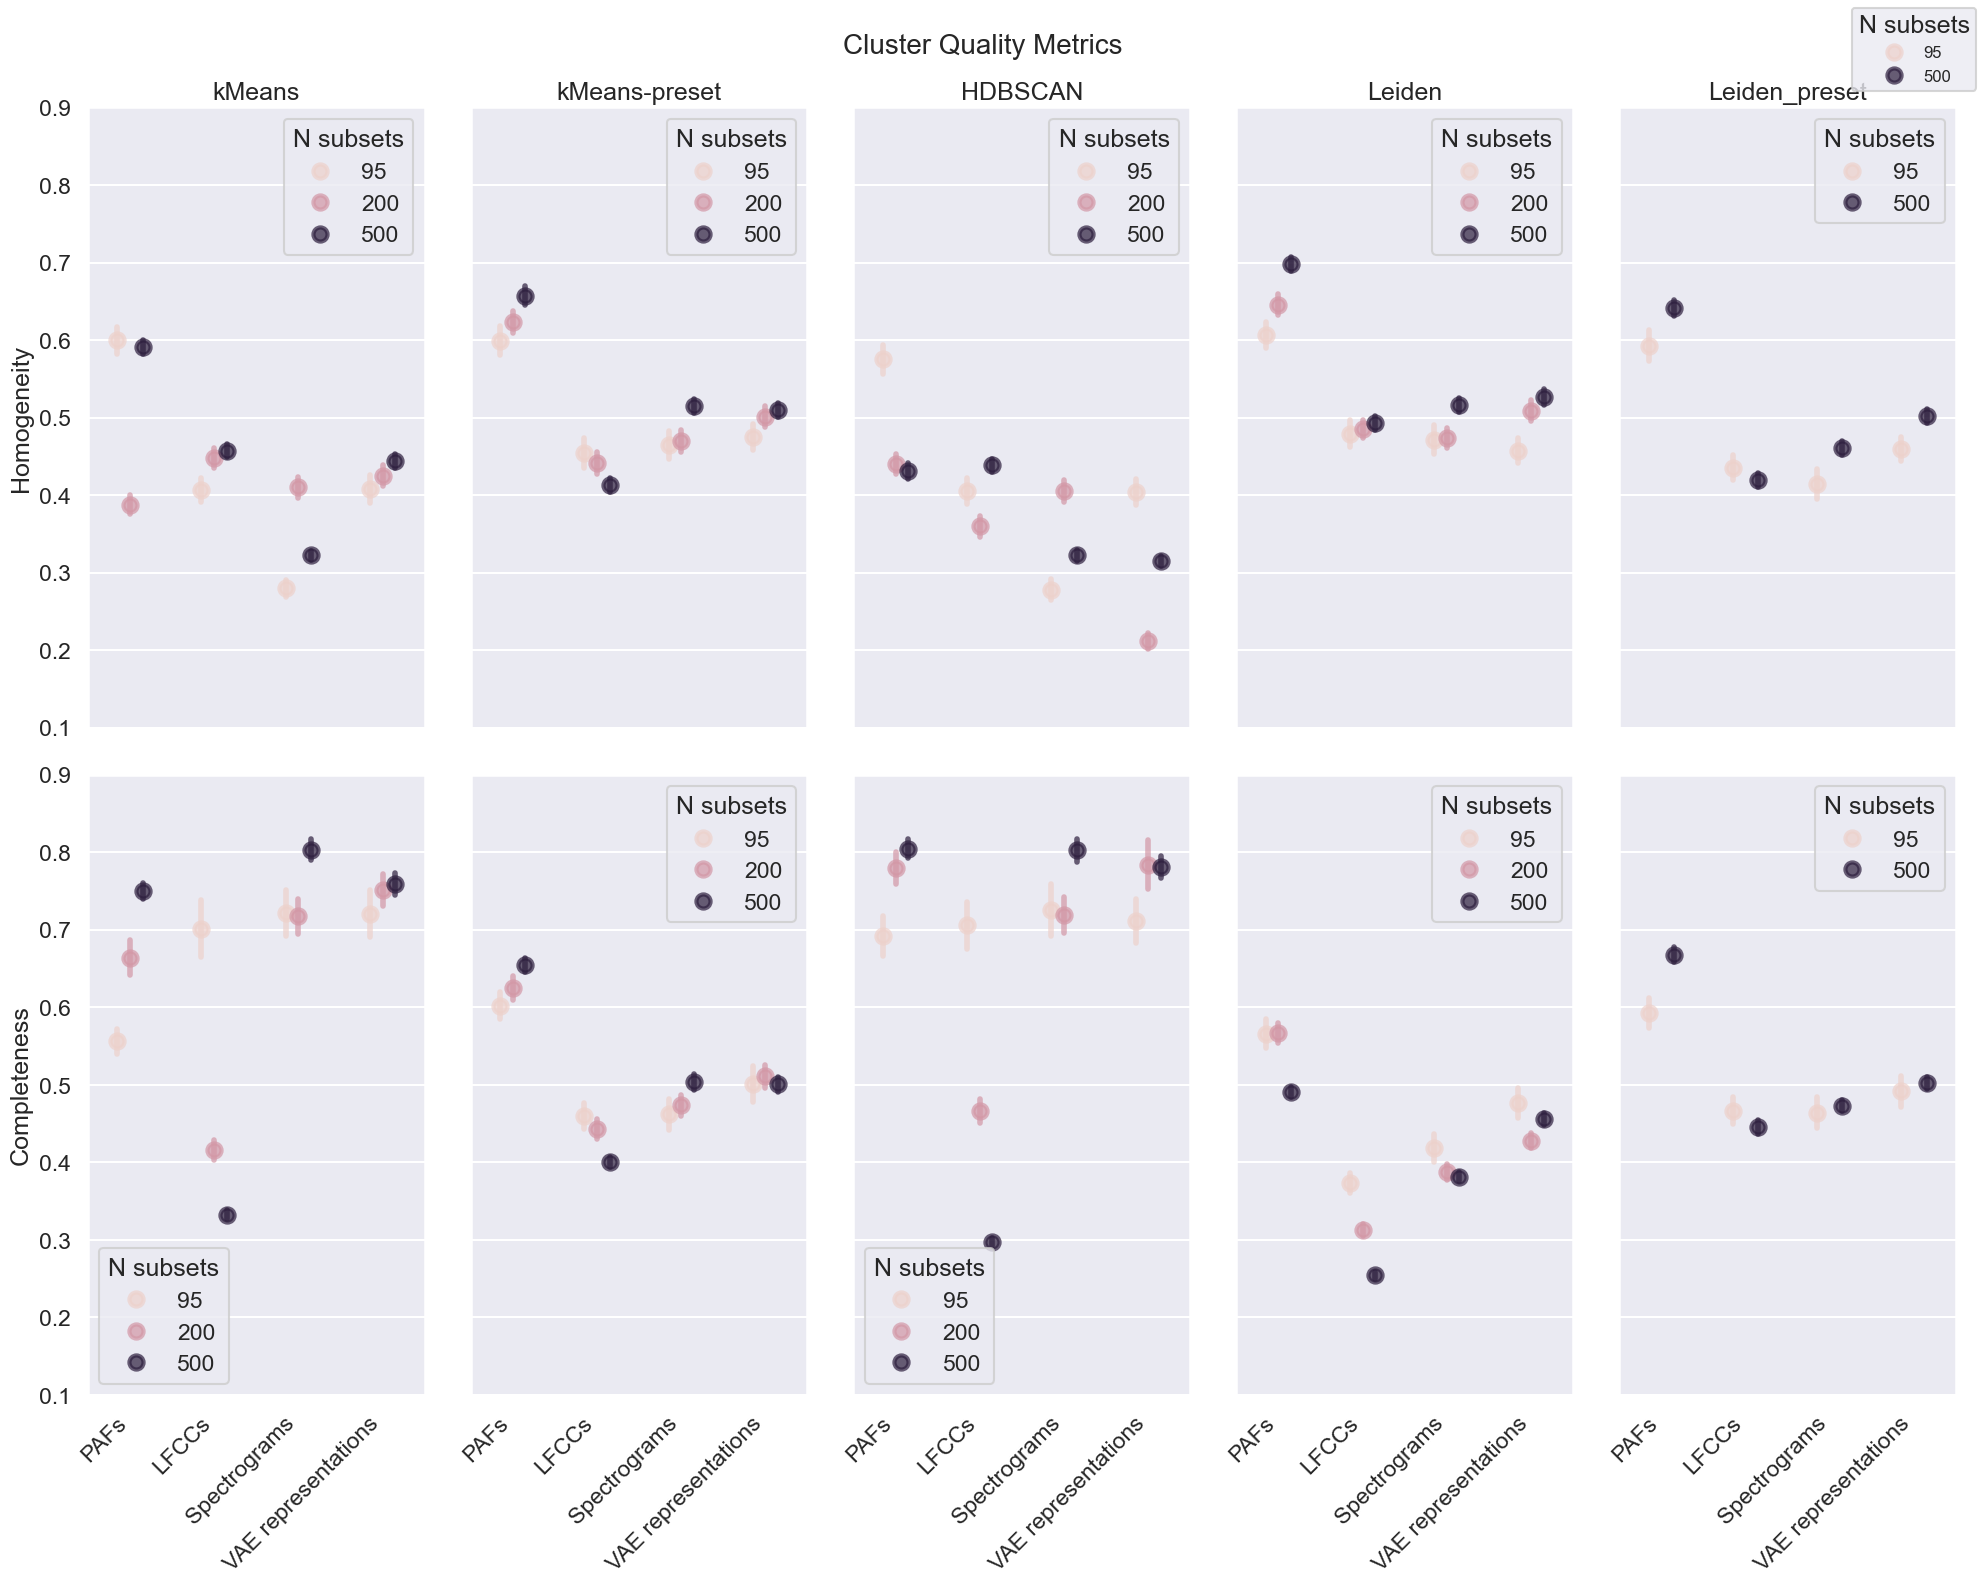

In [94]:
true_vs_pred_df_exploded_filtered = true_vs_pred_df_exploded[
    (true_vs_pred_df_exploded["Alarm call subset"] == "yes") &
    (true_vs_pred_df_exploded["Distance metric"] == "l2")
]

columns = algorithm_keys
representations = ['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations']
rows = ["Homogeneity", "Completeness"]

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 16), sharex=True, sharey=True)


for row, metric in enumerate(rows):
    for col, column in enumerate(columns):
        sns.pointplot(
            x="Representation", 
            y=metric,  
            data=true_vs_pred_df_exploded_filtered[true_vs_pred_df_exploded_filtered["Algorithm"] == column], 
            ax=axs[row, col], 
            hue="N subsets", 
            linestyle="none",
            alpha=.7,
            errorbar="sd",
            dodge=.3,
        )

        if row == 0:
            axs[row, col].set_title(column)

        axs[row, col].set_ylim(0.1, 0.9)
        axs[row, col].set_xticklabels(representations, rotation=45, ha='right')
        axs[row, col].set_xlabel('')

        if col == 0:
            axs[row, col].set_ylabel(metric)  # Label only the first column
        else:
            axs[row, col].set_ylabel('')

handles, labels = axs[0, -1].get_legend_handles_labels()
fig.legend(handles, labels, title="N subsets", loc="upper right", fontsize=12)

fig.suptitle("Cluster Quality Metrics", fontsize=20)
plt.tight_layout()
plt.show()


/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_92165/2878450241.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(representations, rotation=45, ha='right')
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_92165/2878450241.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(representations, rotation=45, ha='right')
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_92165/2878450241.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(representations, rotation=45, ha='right')
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_92165/2878450241.py:23: UserWarning: set_ticklabels() should only be used with a fixed

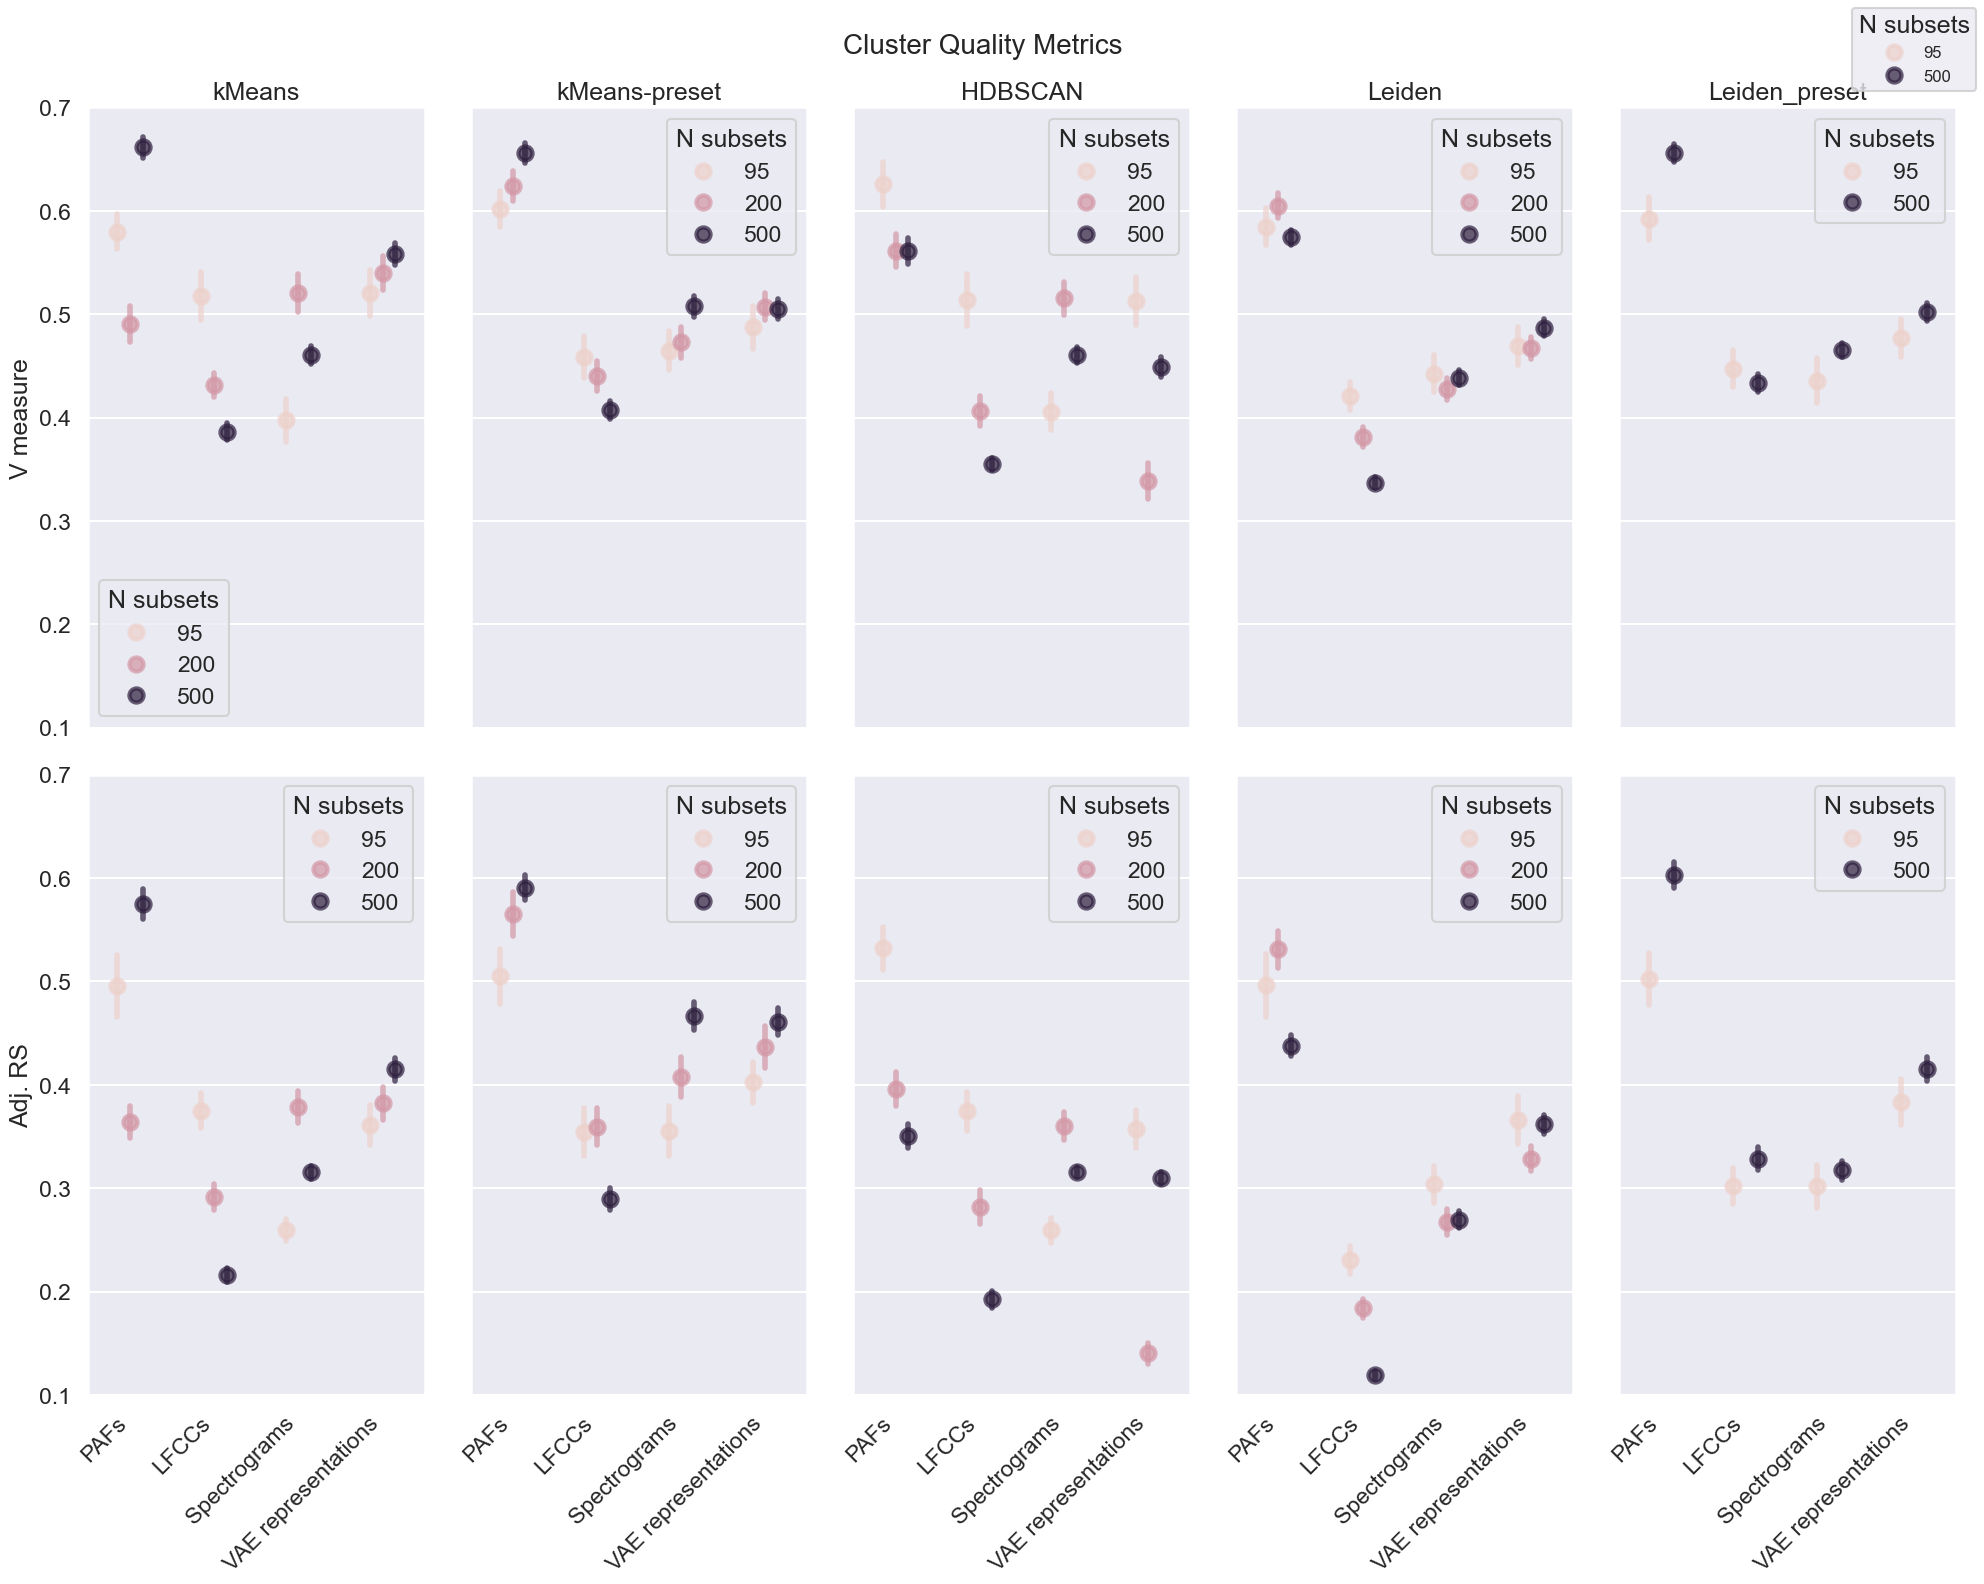

In [96]:
rows = ["V measure", "Adj. RS"]

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 16), sharex=True, sharey=True)

for row, metric in enumerate(rows):
    for col, column in enumerate(columns):
        sns.pointplot(
            x="Representation", 
            y=metric,  
            data=true_vs_pred_df_exploded_filtered[true_vs_pred_df_exploded_filtered["Algorithm"] == column], 
            ax=axs[row, col], 
            hue="N subsets", 
            linestyle="none",
            alpha=.7,
            errorbar="sd",
            dodge=.3,
        )

        if row == 0:
            axs[row, col].set_title(column)

        axs[row, col].set_ylim(0.1, 0.7)
        axs[row, col].set_xticklabels(representations, rotation=45, ha='right')
        axs[row, col].set_xlabel('')

        if col == 0:
            axs[row, col].set_ylabel(metric)  # Label only the first column
        else:
            axs[row, col].set_ylabel('')

handles, labels = axs[0, -1].get_legend_handles_labels()
fig.legend(handles, labels, title="N subsets", loc="upper right", fontsize=12)

fig.suptitle("Cluster Quality Metrics", fontsize=20)
plt.tight_layout()
plt.show()


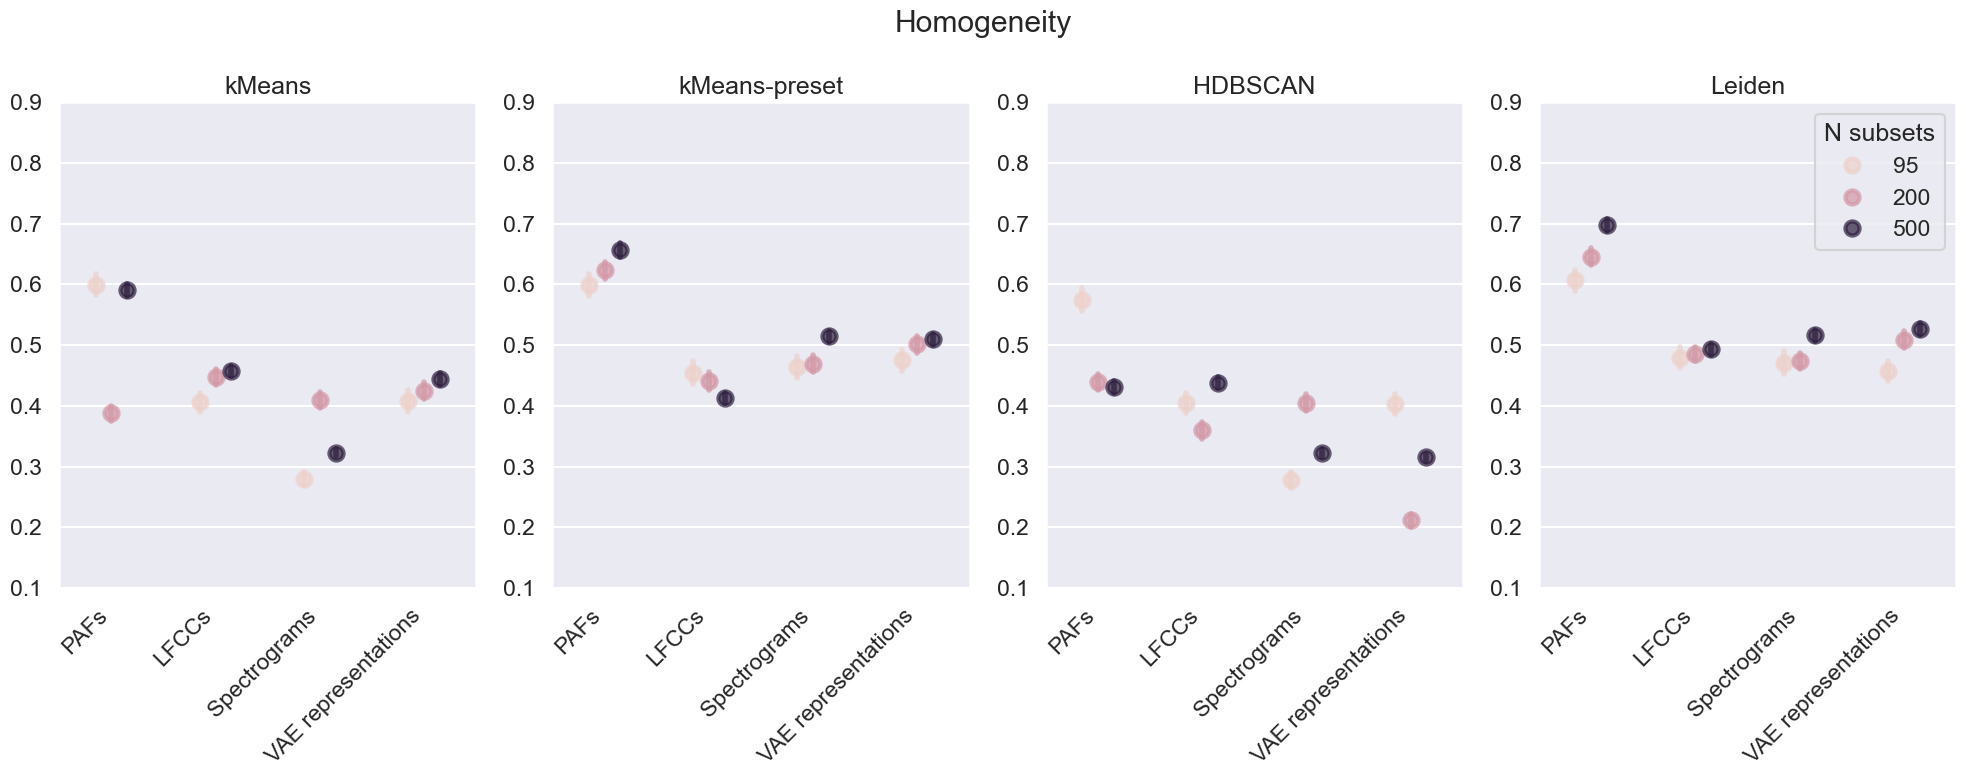

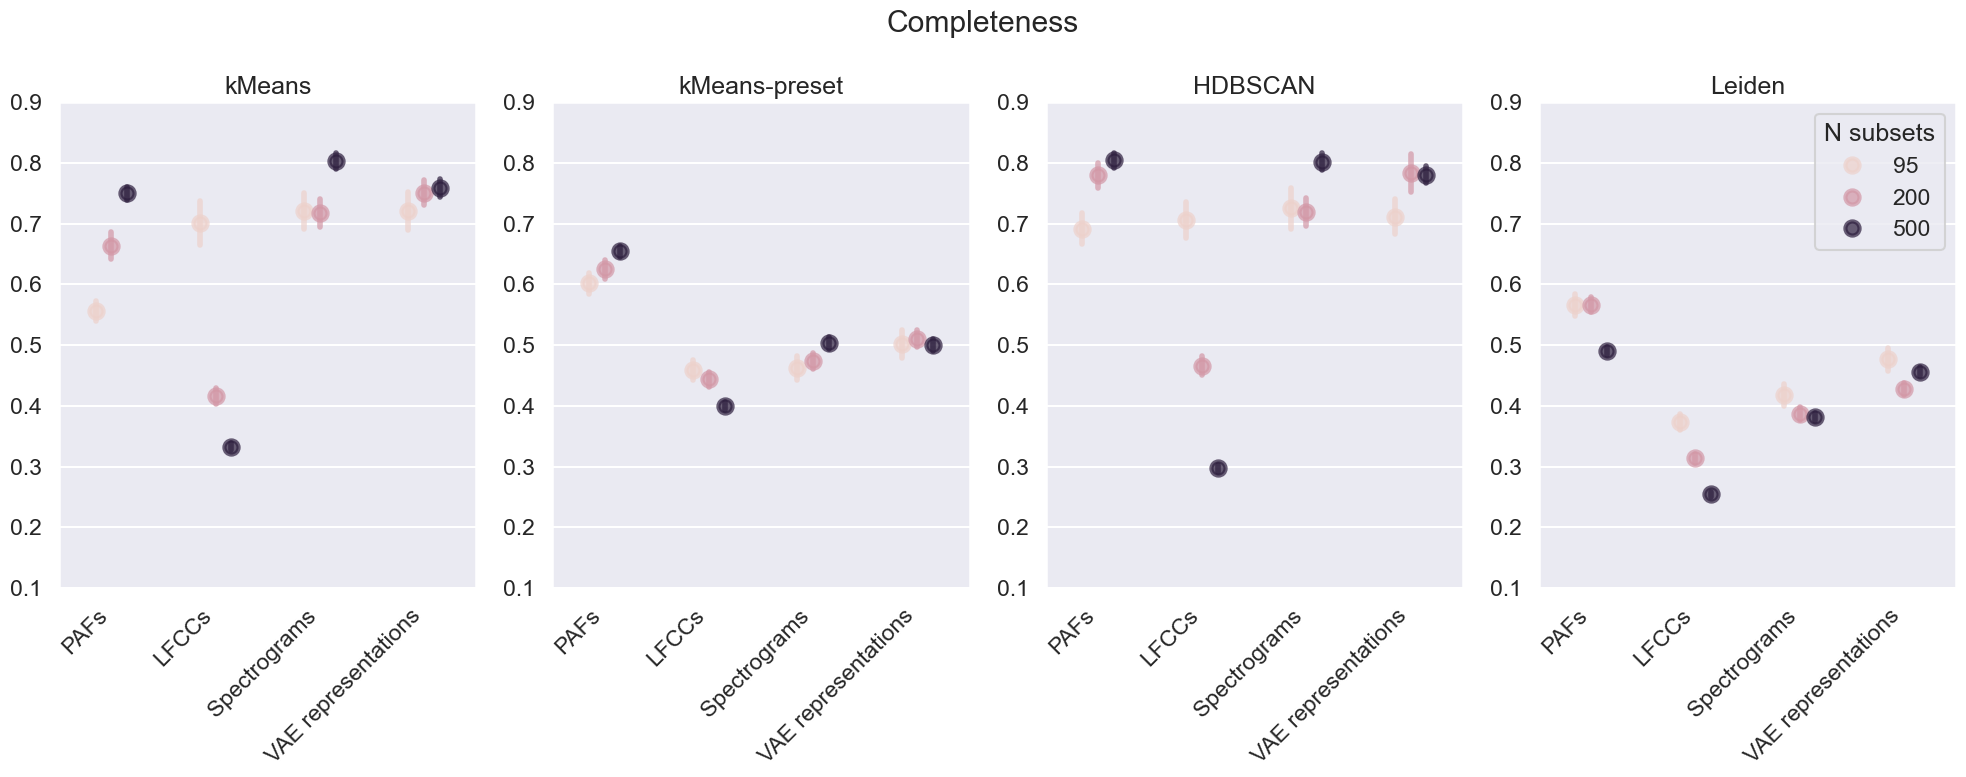

In [97]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 8))

columns = ["kMeans", "kMeans-preset", "HDBSCAN", "Leiden"]
for i, column in enumerate(columns):
    sns.pointplot(
        x="Representation", 
        y="Homogeneity", 
        data=true_vs_pred_df_exploded_filtered[true_vs_pred_df_exploded_filtered["Algorithm"]==column], 
        ax=axs[i], 
        hue="N subsets", 
        legend=(True if i == len(columns)-1 else False),
        linestyle="none",
        alpha=.7,
        errorbar="sd",
        dodge=.3,
    )

    axs[i].set_ylim(.1,.9)
    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

fig.suptitle("Homogeneity")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(ncols=4, figsize=(20, 8))

columns = ["kMeans", "kMeans-preset", "HDBSCAN", "Leiden"]
for i, column in enumerate(columns):
    sns.pointplot(
        x="Representation", 
        y="Completeness", 
        data=true_vs_pred_df_exploded_filtered[true_vs_pred_df_exploded_filtered["Algorithm"]==column], 
        ax=axs[i], 
        hue="N subsets", 
        legend=(True if i == len(columns)-1 else False),
        linestyle="none",
        alpha=.7,
        errorbar="sd",
        dodge=.3,
    )

    axs[i].set_ylim(.1,.9)
    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

fig.suptitle("Completeness")
plt.tight_layout()
plt.show()

In [98]:
rows = []
for di in dicts:
    for representation in representation_keys:
        for algorithm in algorithm_keys:
            v_measure, st_err, ci_low, ci_high, p_value, chance_level, _ = stats.v_measure_against_chance(
                di["true_labels"], 
                di[representation][algorithm],  
                plot=False)
            
            rows.append([
                di["n"], 
                di["distance_metric"], 
                di["alarm"],
                representation,
                algorithm,
                v_measure,
                st_err,
                ci_low,
                ci_high,
                p_value,
                chance_level, 
                homogeneity_score(di["true_labels"], di[representation][algorithm]),
                completeness_score(di["true_labels"], di[representation][algorithm]),
                adjusted_rand_score(di["true_labels"], di[representation][algorithm])
            ])

true_vs_pred_df_single_rows = pd.DataFrame(
    rows, 
    columns=["N subsets", "Distance metric", "Alarm call subset", "Representation", "Algorithm", "V measure", "st_err", "ci_low", "ci_high", "p-value", "Chance level", "Homogeneity", "Completeness", "Adj. RS"]
)

print(true_vs_pred_df_single_rows)

KeyError: 'Leiden_preset'

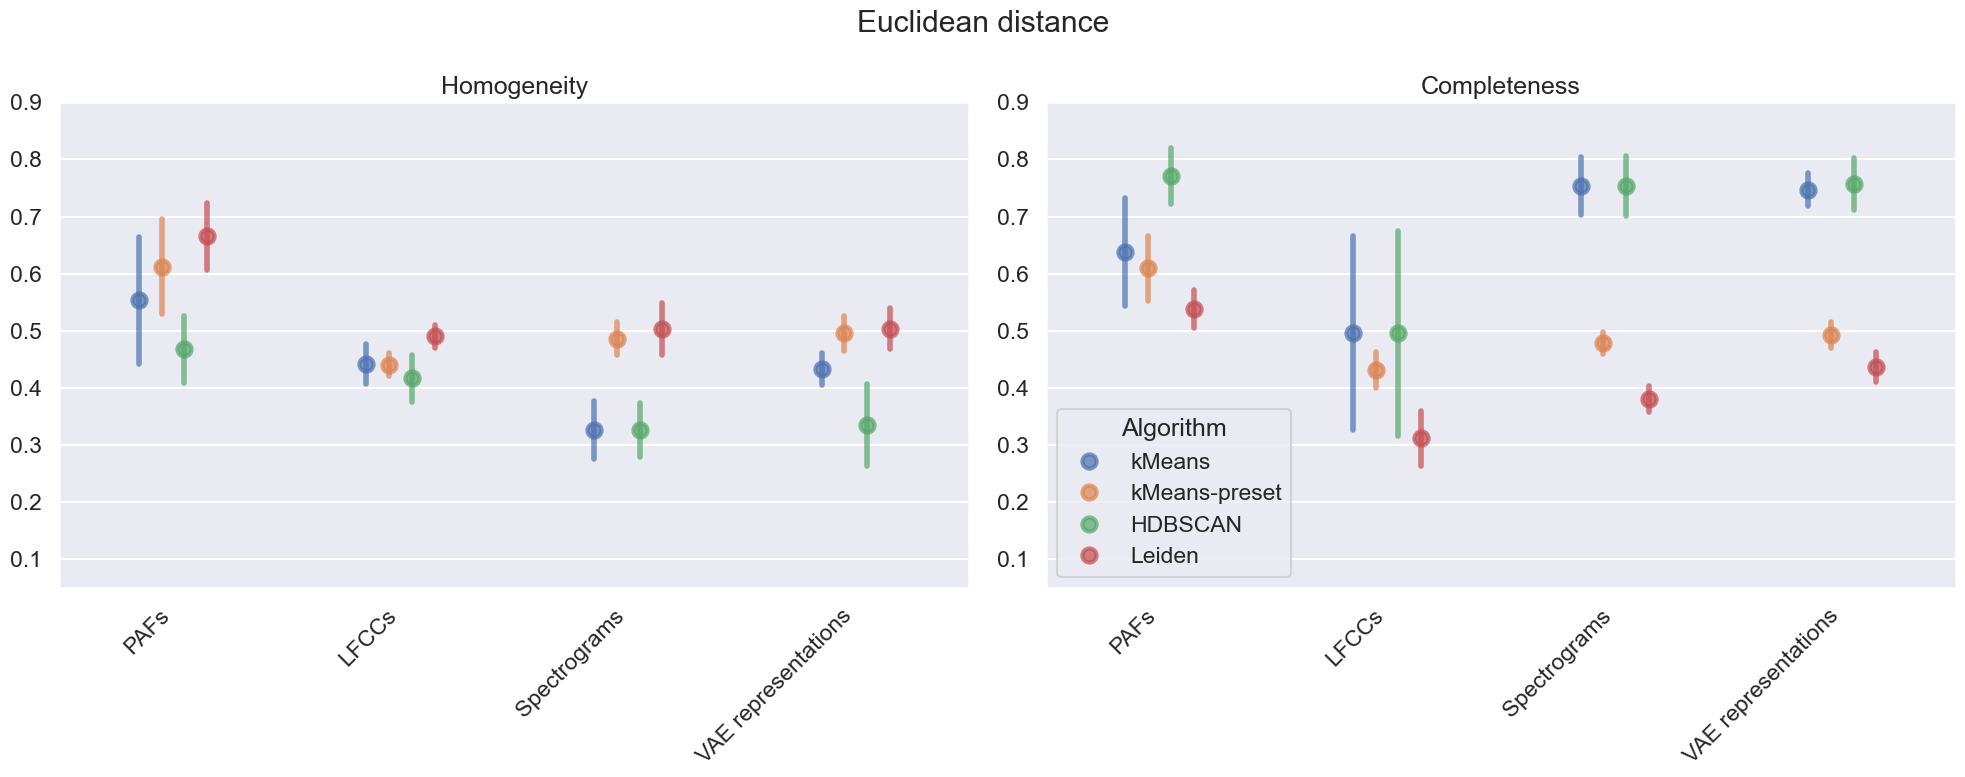

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

columns = ["Homogeneity", "Completeness"]
for i, column in enumerate(columns):
    # Raw datapoints
    sns.pointplot(
        x="Representation", 
        y=column, 
        data=true_vs_pred_df_exploded, 
        ax=axs[i], 
        hue="Algorithm", 
        legend=(True if i == len(columns)-1 else False),
        linestyle="none",
        alpha=.7,
        errorbar="sd",
        dodge=.3,
    )
    
    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_ylim(0.05, .9)

fig.suptitle("Euclidean distance")
plt.tight_layout()
plt.show()
# Homogeneity: measures to what proportion clusters contain only data points with the same label
# Completensess: measures if all members of the same class are also members of the same cluster

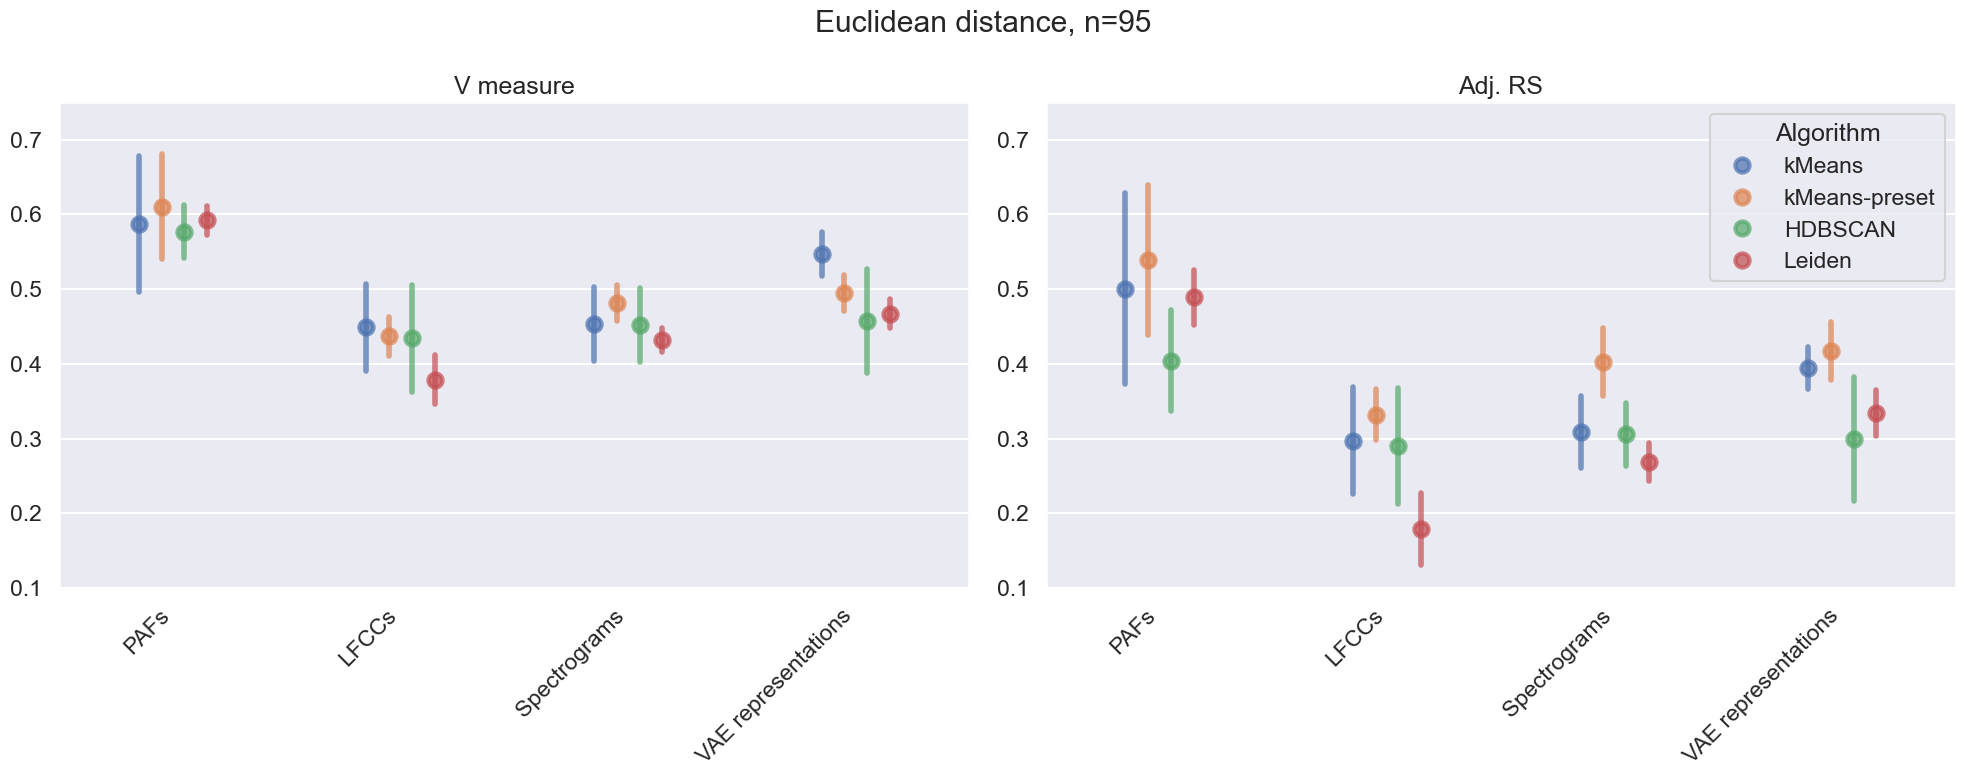

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

columns = ["V measure", "Adj. RS"]
for i, column in enumerate(columns):
    # Raw datapoints
    sns.pointplot(
        x="Representation", 
        y=column, 
        data=true_vs_pred_df_exploded, 
        ax=axs[i], 
        hue="Algorithm", 
        legend=(True if i == len(columns)-1 else False),
        linestyle="none",
        alpha=.7,
        errorbar="sd",
        dodge=.3,
    )
    
    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_ylim(0.1, .75)

fig.suptitle("Euclidean distance, n=95")
plt.tight_layout()
plt.show()
# Homogeneity: measures to what proportion clusters contain only data points with the same label
# Completensess: measures if all members of the same class are also members of the same cluster

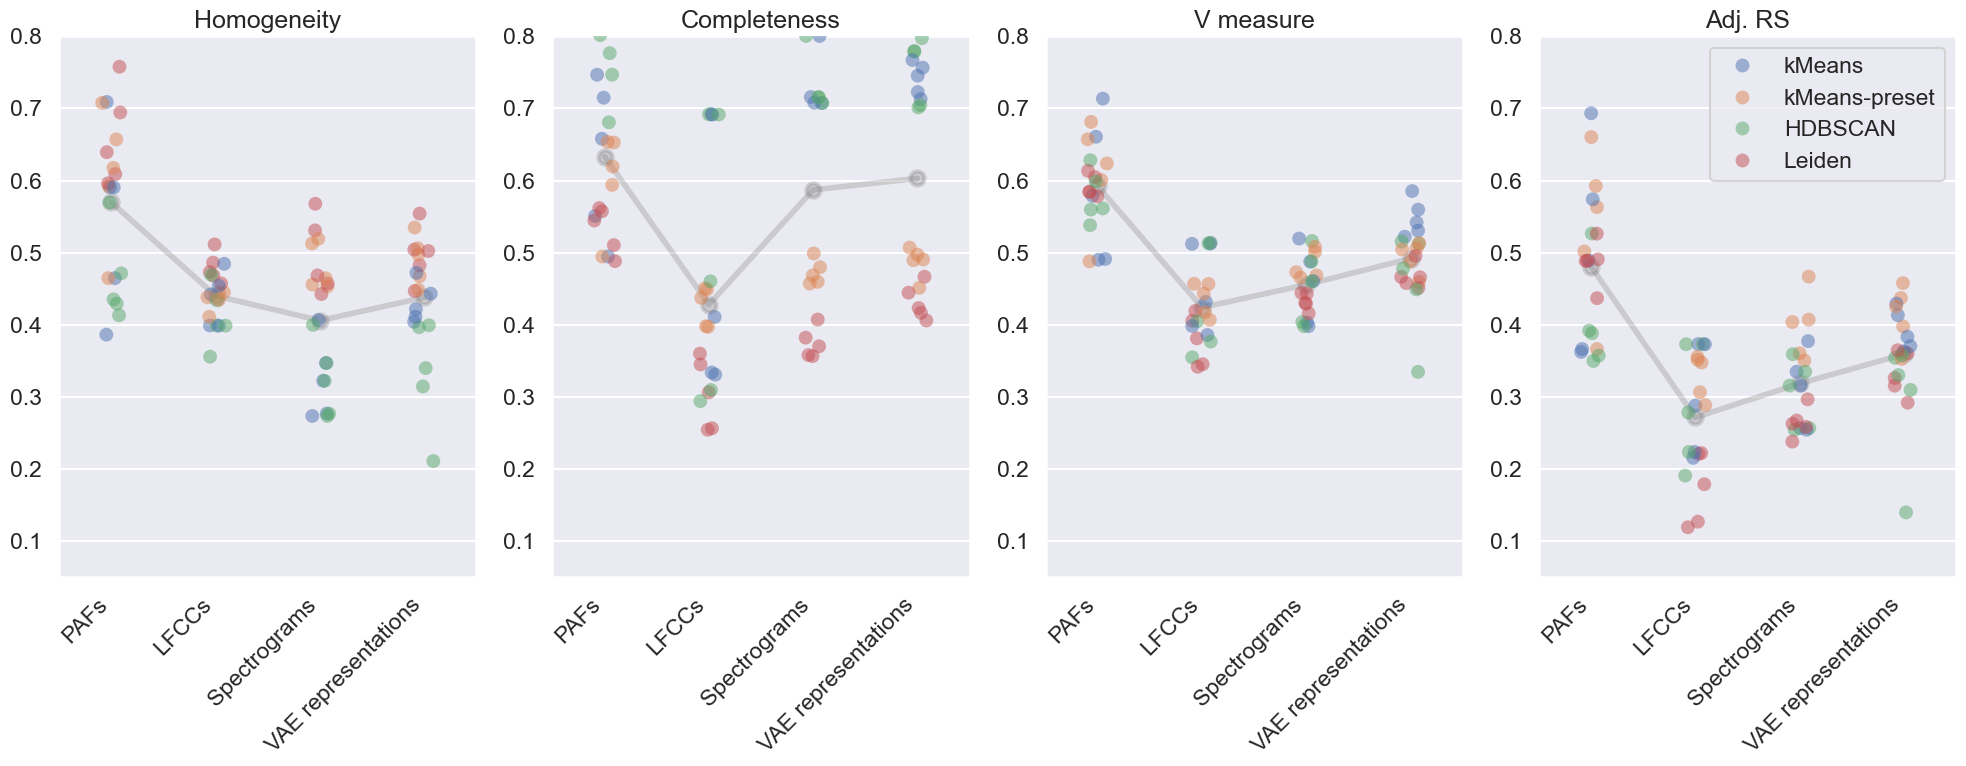

In [18]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 8))

columns = ["Homogeneity", "Completeness", "V measure", "Adj. RS"]
for i, column in enumerate(columns):
    # Raw data points
    sns.stripplot(
        x="Representation", 
        y=column, 
        data=true_vs_pred_df_single_rows, 
        ax=axs[i], 
        jitter=True, 
        size=10, 
        hue="Algorithm", 
        alpha=0.5, 
        legend=(True if i == len(columns)-1 else False)
    )
    
    # Mean points
    sns.pointplot(
        x="Representation", 
        y=column, 
        data=true_vs_pred_df_single_rows, 
        ax=axs[i], 
        errorbar=None,
        markers="o", 
        color="grey",
        alpha=.3
    )

    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_ylim(0.05, 0.8)

plt.tight_layout()
plt.show()
# Homogeneity: measures to what proportion clusters contain only data points with the same label
# Completensess: measures if all members of the same class are also members of the same cluster

In [19]:
# Generate LaTeX Table
latex_table = true_vs_pred_df.to_latex(
    index=True,
    multirow=True,
    caption="Clustering Metrics for Representations",
    label="tab:clustering_metrics",
    na_rep="---",
)

print(latex_table)

\begin{table}
\caption{Clustering Metrics for Representations}
\label{tab:clustering_metrics}
\begin{tabular}{lrllllrrllll}
\toprule
 & N subsets & Distance metric & Alarm call subset & Representation & Algorithm & p-value & Chance level & V measure & Homogeneity & Completeness & Adj. RS \\
\midrule
0 & 95 & l2 & yes & PAFs & kMeans & 0.000000 & 0.014226 & [0.56378746 0.56596571 0.56297203 0.57150732 0.57749498 0.57856191
 0.58712757 0.56797095 0.57694546 0.57410693 0.56588071 0.57917108
 0.60602717 0.55694227 0.58114919 0.59760816 0.60155497 0.5856528
 0.57734371 0.56846809 0.60935914 0.55119425 0.57408766 0.59422671
 0.58179257 0.59709786 0.55013192 0.61074037 0.55532476 0.56519397
 0.58892078 0.58080946 0.58368291 0.60631973 0.52890706 0.59212388
 0.57324512 0.57256339 0.59169807 0.5826167  0.58550061 0.57691895
 0.56957838 0.59354535 0.58723336 0.56692371 0.57273266 0.55004629
 0.62204373 0.58214867 0.57385475 0.55457451 0.59412362 0.56790684
 0.56996463 0.5821252  0.60999064 0.596

#### Compare algorithms

In [20]:
true_vs_pred_df.head()

,N subsets,Distance metric,Alarm call subset,Representation,Algorithm,p-value,Chance level,V measure,Homogeneity,Completeness,Adj. RS
0,95,l2,yes,PAFs,kMeans,0.0,0.014226,"[0.5637874585789181, 0.5659657148192363, 0.562...","[0.6045849933022047, 0.6016613455068951, 0.618...","[0.550803917714766, 0.5760987975570562, 0.5612...","[0.4952529439061614, 0.5200540057689661, 0.497..."
1,95,l2,yes,PAFs,kMeans-preset,0.0,0.012421,"[0.5676430593096328, 0.580528281673778, 0.6144...","[0.589418343571076, 0.5660727955267391, 0.5970...","[0.5914825720087779, 0.6033281836492455, 0.625...","[0.49336177324556696, 0.4774992799758708, 0.49..."
2,95,l2,yes,PAFs,HDBSCAN,0.0,0.010340,"[0.6231498817598351, 0.6494809835498071, 0.678...","[0.6193531303148412, 0.5855143173233526, 0.556...","[0.6860363457313648, 0.6593038002323944, 0.705...","[0.5256661430925941, 0.5316014402890994, 0.530..."
3,95,l2,yes,PAFs,Leiden,0.0,0.014631,"[0.5755026690738786, 0.6022358345744133, 0.634...","[0.6094682278487132, 0.5946490693056596, 0.595...","[0.5952534875429186, 0.5414891712222015, 0.583...","[0.5051881123367771, 0.43740031927896816, 0.49..."
4,95,l2,yes,LFCCs,kMeans,0.0,0.005988,"[0.4822399476937519, 0.5065130981468712, 0.517...","[0.3845770540320931, 0.4075603898858216, 0.399...","[0.6731772827773916, 0.693797968447449, 0.7175...","[0.4219697373918569, 0.3734389631607861, 0.390..."


In [21]:
rows = []
for n in (95, 200, 500):
    for representation in representation_keys:
        for algorithm_a, algorithm_b in itertools.combinations(algorithm_keys, 2):
            df_a = true_vs_pred_df[
                (true_vs_pred_df["N subsets"] == n) &
                (true_vs_pred_df["Distance metric"] == "l2") &
                (true_vs_pred_df["Alarm call subset"] == "yes") &
                (true_vs_pred_df["Representation"] == representation) &
                (true_vs_pred_df["Algorithm"] == algorithm_a)
            ]

            df_b = true_vs_pred_df[
                (true_vs_pred_df["N subsets"] == n) &
                (true_vs_pred_df["Distance metric"] == "l2") &
                (true_vs_pred_df["Alarm call subset"] == "yes") &
                (true_vs_pred_df["Representation"] == representation) &
                (true_vs_pred_df["Algorithm"] == algorithm_b)
            ]

            if len(df_a["Adj. RS"].values[0]) == len(df_b["Adj. RS"].values[0]) and len(df_b["Adj. RS"].values[0]) > 1:
                rand_res = ttest_rel(df_a["Adj. RS"].values[0], df_b["Adj. RS"].values[0])
                V_res = ttest_rel(df_a["V measure"].values[0], df_b["V measure"].values[0])

                # Append results
                rows.append([
                    n, "l2", "yes", representation, algorithm_a, algorithm_b,
                    rand_res.statistic, rand_res.pvalue,
                    V_res.statistic, V_res.pvalue
                ])

# Convert to DataFrame
match_scores_across_results = pd.DataFrame(
    rows, 
    columns=["N subsets", "Distance metric", "Alarm call subset", "Representation", "Algorithm A", "Algorithm B", 
             "Adjusted Rand Score", "Adjusted Rand Score - p-value",
             "V Measure Score", "V Measure Score - p-value"]
)

match_scores_across_results

,N subsets,Distance metric,Alarm call subset,Representation,Algorithm A,Algorithm B,Adjusted Rand Score,Adjusted Rand Score - p-value,V Measure Score,V Measure Score - p-value
0,95,l2,yes,PAFs,kMeans,kMeans-preset,-2.439753,1.647612e-02,-8.537932,1.666855e-13
1,95,l2,yes,PAFs,kMeans,HDBSCAN,-10.446185,1.165550e-17,-15.632281,1.733706e-28
2,95,l2,yes,PAFs,kMeans,Leiden,-0.333309,7.396061e-01,-1.805317,7.406456e-02
3,95,l2,yes,PAFs,kMeans-preset,HDBSCAN,-6.740044,1.062765e-09,-8.804657,4.403340e-14
4,95,l2,yes,PAFs,kMeans-preset,Leiden,1.995742,4.870935e-02,7.975480,2.708714e-12
...,...,...,...,...,...,...,...,...,...,...
67,500,l2,yes,VAE representations,kMeans,HDBSCAN,84.079616,7.023952e-94,86.016516,7.593698e-95
68,500,l2,yes,VAE representations,kMeans,Leiden,73.812214,2.285490e-88,79.940806,9.675552e-92
69,500,l2,yes,VAE representations,kMeans-preset,HDBSCAN,97.820663,2.601697e-100,45.648111,2.607021e-68
70,500,l2,yes,VAE representations,kMeans-preset,Leiden,85.975021,7.960278e-95,39.866818,8.714872e-63


In [22]:
print(true_vs_pred_df_exploded['Representation'].unique())

['PAFs' 'LFCCs' 'Spectrograms' 'VAE representations']


/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_92165/1733857504.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(representations, rotation=45, ha='right')
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_92165/1733857504.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(representations, rotation=45, ha='right')
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_92165/1733857504.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(representations, rotation=45, ha='right')
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_92165/1733857504.py:38: UserWarning: set_ticklabels() should only be used with a fixed

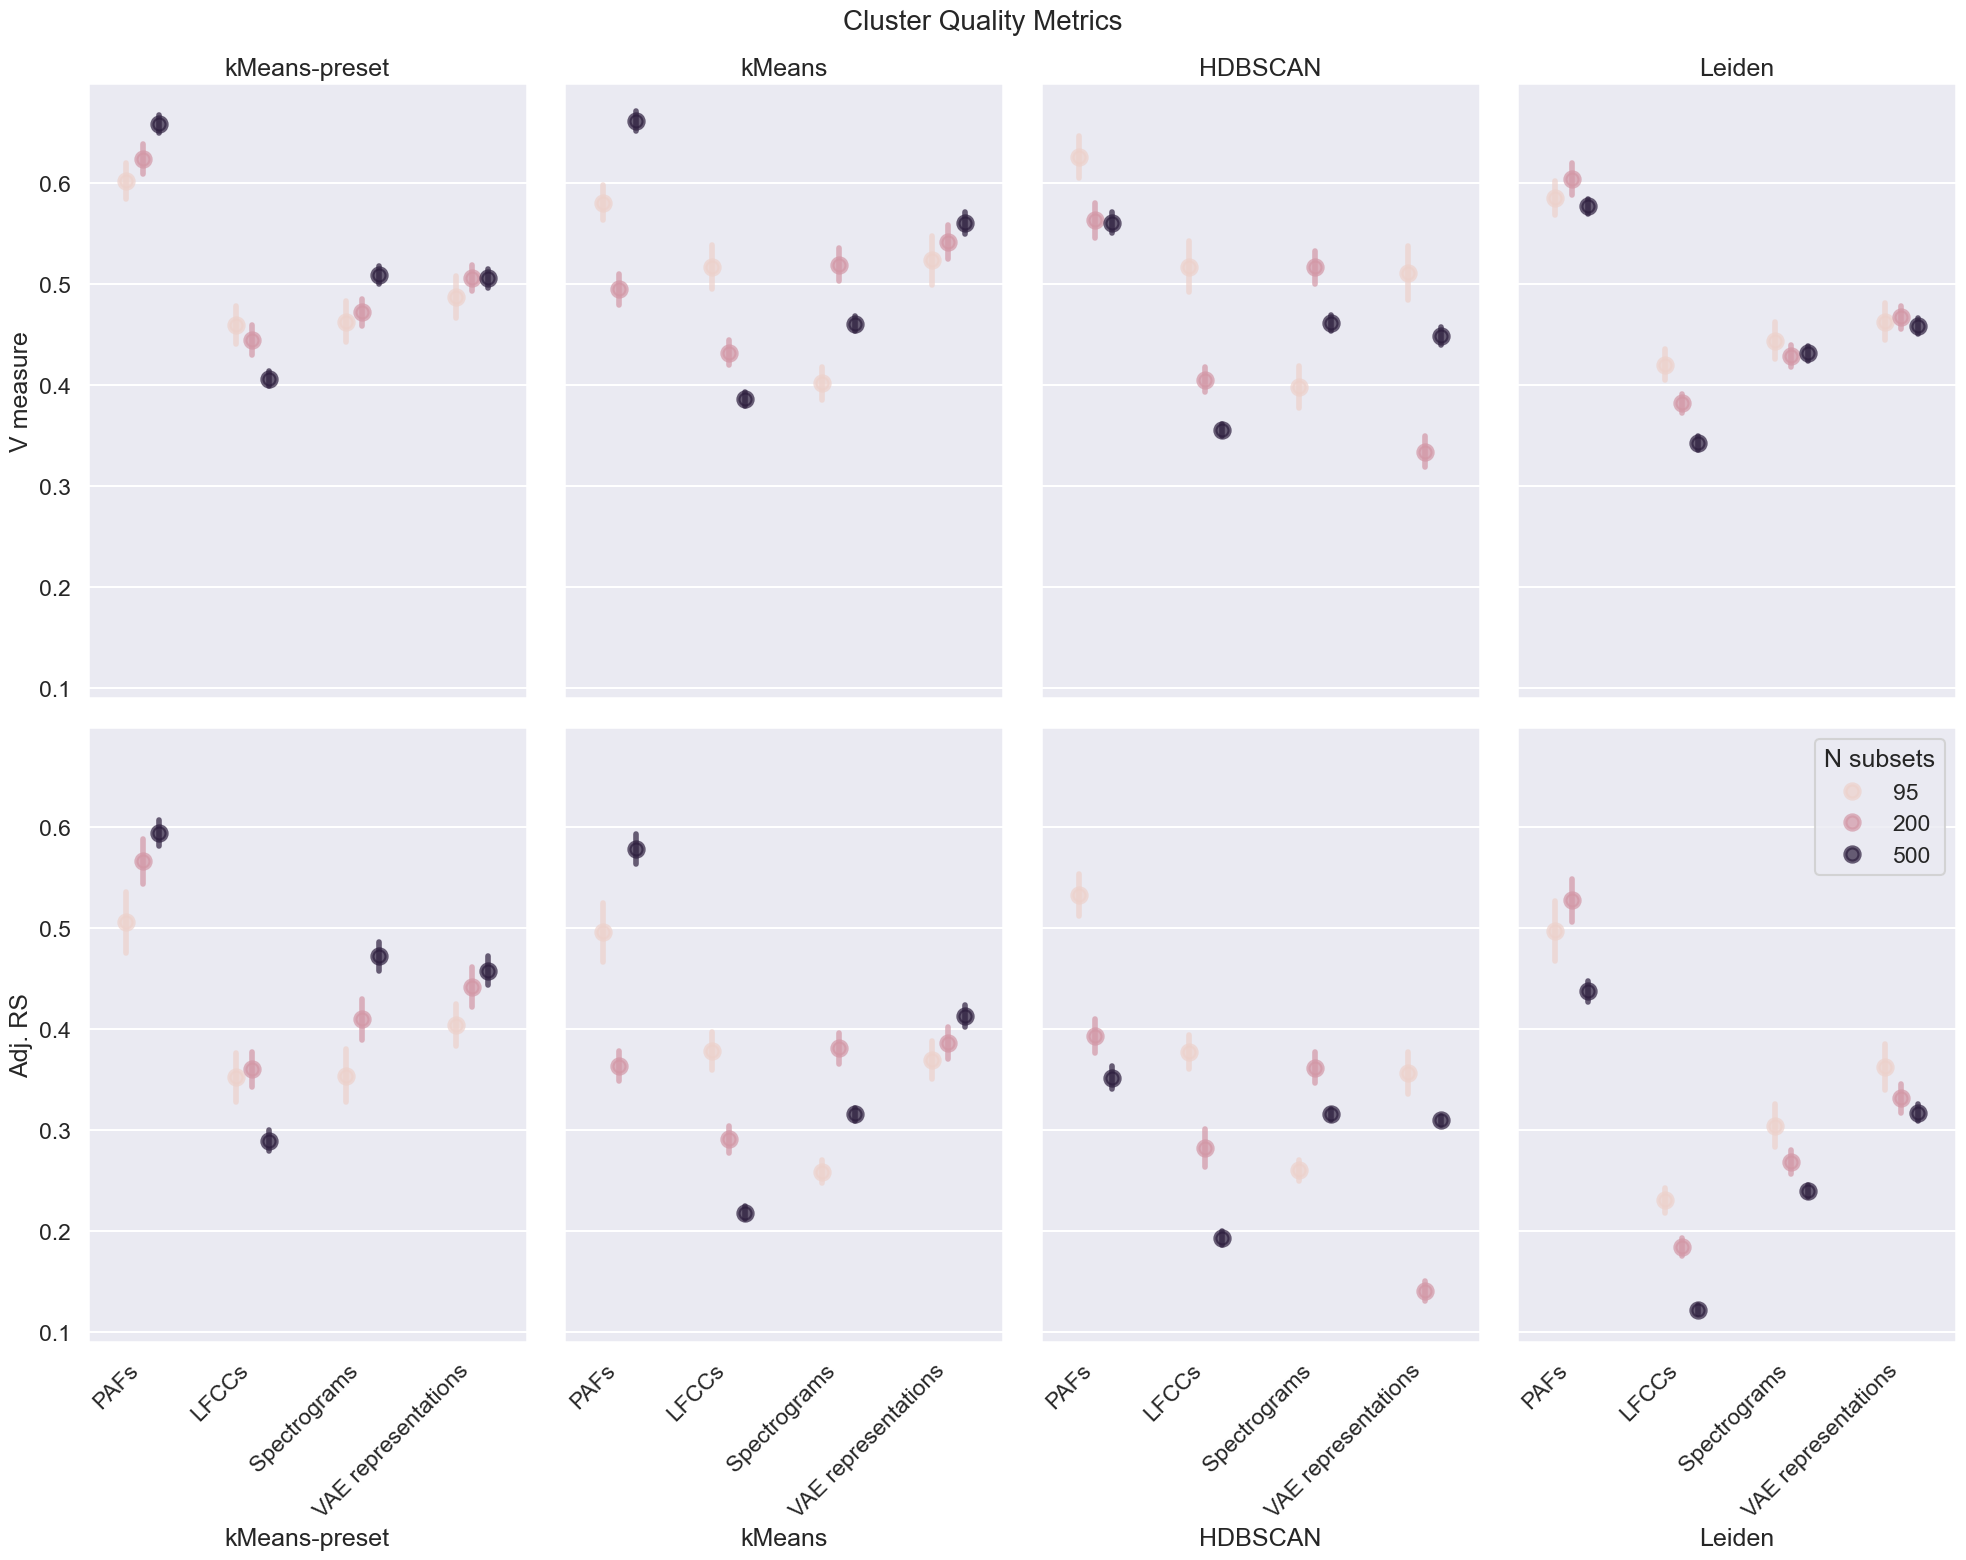

In [ ]:
from statannotations.Annotator import Annotator
rows = ["V measure", "Adj. RS"]
columns = ["kMeans-preset", "kMeans", "HDBSCAN", "Leiden"]
pairs = [("PAFs", "LFCCs"), 
       ("PAFs", "Spectrograms"), 
       ("PAFs", "VAE representations"), 
       ("LFCCs", "Spectrograms"), 
       ("LFCCs", "VAE representations"), 
       ("Spectrograms", "VAE representations")]

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 16), sharex=True, sharey=True)
for row, metric in enumerate(rows):
    for col, representation in enumerate(columns):
        data = true_vs_pred_df_exploded_filtered[true_vs_pred_df_exploded_filtered["Algorithm"] == representation]

        sns.pointplot(
            x="Representation", 
            y=metric,  
            data=data, 
            ax=axs[row, col], 
            hue="N subsets", 
            linestyle="none",
            alpha=.7,
            errorbar="sd",
            dodge=.3,
            legend=(True if row==1 and col==3 else False)
        )
        # annotator = Annotator(axs[row, col], data=data, x="Representation", y=metric, pairs=pairs)
        # annotator.configure(test='t-test_paired', text_format='star', loc='outside')
        # annotator.apply_and_annotate()

        # all p <= 1.00e-04

        if row == 0:
            axs[row, col].set_title(representation)

        #axs[row, col].set_ylim(0.1, 0.7)
        axs[row, col].set_xticklabels(representations, rotation=45, ha='right')
        axs[row, col].set_xlabel(representation)

        if col == 0:
            axs[row, col].set_ylabel(metric)  # Label only the first column
        else:
            axs[row, col].set_ylabel('')

fig.suptitle("Cluster Quality Metrics", fontsize=20)
plt.tight_layout()
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

kMeans vs. kMeans-preset: t-test paired samples, P_val:9.738e-35 t=-1.404e+01
kMeans-preset vs. HDBSCAN: t-test paired samples, P_val:2.696e-34 t=1.392e+01
HDBSCAN vs. Leiden: t-test paired samples, P_val:2.555e-02 t=-2.244e+00
kMeans-preset vs. Leiden: t-test paired samples, P_val:1.912e-54 t=1.929e+01
kMeans vs. HDBSCAN: t-test paired samples, P_val:3.240e-01 t=-9.878e-01
kMeans vs. Leiden: t-test paired samples, P_val:4.048e-02 t=-2.058e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

kMeans vs. kMeans-preset: t-test paired samples, P_val:5.158e-04 t=3.511e+00


/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_92165/1575292097.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(algorithm_keys, rotation=45, ha='right')


kMeans-preset vs. HDBSCAN: t-test paired samples, P_val:7.029e-04 t=3.424e+00
HDBSCAN vs. Leiden: t-test paired samples, P_val:1.628e-50 t=1.825e+01
kMeans-preset vs. Leiden: t-test paired samples, P_val:1.089e-137 t=4.601e+01
kMeans vs. HDBSCAN: t-test paired samples, P_val:1.291e-29 t=1.264e+01
kMeans vs. Leiden: t-test paired samples, P_val:3.329e-112 t=3.651e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

kMeans vs. kMeans-preset: t-test paired samples, P_val:4.948e-11 t=-6.823e+00


/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_92165/1575292097.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(algorithm_keys, rotation=45, ha='right')


kMeans-preset vs. HDBSCAN: t-test paired samples, P_val:1.301e-12 t=7.410e+00
HDBSCAN vs. Leiden: t-test paired samples, P_val:7.968e-12 t=7.122e+00
kMeans-preset vs. Leiden: t-test paired samples, P_val:1.732e-78 t=2.593e+01
kMeans vs. HDBSCAN: t-test paired samples, P_val:1.505e-01 t=1.442e+00
kMeans vs. Leiden: t-test paired samples, P_val:1.615e-13 t=7.733e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

kMeans vs. kMeans-preset: t-test paired samples, P_val:4.234e-92 t=2.998e+01


/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_92165/1575292097.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(algorithm_keys, rotation=45, ha='right')


kMeans-preset vs. HDBSCAN: t-test paired samples, P_val:3.515e-35 t=1.416e+01
HDBSCAN vs. Leiden: t-test paired samples, P_val:2.267e-11 t=-6.952e+00
kMeans-preset vs. Leiden: t-test paired samples, P_val:8.706e-84 t=2.748e+01
kMeans vs. HDBSCAN: t-test paired samples, P_val:3.812e-68 t=2.301e+01
kMeans vs. Leiden: t-test paired samples, P_val:7.344e-145 t=4.898e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

kMeans vs. kMeans-preset: t-test paired samples, P_val:1.693e-34 t=-1.397e+01


/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_92165/1575292097.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(algorithm_keys, rotation=45, ha='right')


kMeans-preset vs. HDBSCAN: t-test paired samples, P_val:4.411e-53 t=1.893e+01
HDBSCAN vs. Leiden: t-test paired samples, P_val:5.593e-34 t=-1.383e+01
kMeans-preset vs. Leiden: t-test paired samples, P_val:5.986e-44 t=1.650e+01
kMeans vs. HDBSCAN: t-test paired samples, P_val:2.213e-12 t=7.326e+00
kMeans vs. Leiden: t-test paired samples, P_val:2.604e-01 t=-1.128e+00


/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_92165/1575292097.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(algorithm_keys, rotation=45, ha='right')


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

kMeans vs. kMeans-preset: t-test paired samples, P_val:2.035e-30 t=-1.286e+01
kMeans-preset vs. HDBSCAN: t-test paired samples, P_val:4.368e-37 t=1.467e+01
HDBSCAN vs. Leiden: t-test paired samples, P_val:2.587e-147 t=5.003e+01
kMeans-preset vs. Leiden: t-test paired samples, P_val:7.182e-213 t=8.596e+01
kMeans vs. HDBSCAN: t-test paired samples, P_val:3.828e-17 t=8.951e+00
kMeans vs. Leiden: t-test paired samples, P_val:1.012e-192 t=7.306e+01


/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_92165/1575292097.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(algorithm_keys, rotation=45, ha='right')


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

kMeans vs. kMeans-preset: t-test paired samples, P_val:3.418e-86 t=-2.819e+01
kMeans-preset vs. HDBSCAN: t-test paired samples, P_val:1.773e-106 t=3.457e+01
HDBSCAN vs. Leiden: t-test paired samples, P_val:7.733e-25 t=1.128e+01
kMeans-preset vs. Leiden: t-test paired samples, P_val:3.087e-95 t=3.095e+01
kMeans vs. HDBSCAN: t-test paired samples, P_val:3.803e-08 t=5.647e+00
kMeans vs. Leiden: t-test paired samples, P_val:1.259e-26 t=1.180e+01


/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_92165/1575292097.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(algorithm_keys, rotation=45, ha='right')


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

kMeans vs. kMeans-preset: t-test paired samples, P_val:4.030e-92 t=-2.998e+01
kMeans-preset vs. HDBSCAN: t-test paired samples, P_val:1.897e-81 t=2.679e+01
HDBSCAN vs. Leiden: t-test paired samples, P_val:1.564e-31 t=-1.316e+01
kMeans-preset vs. Leiden: t-test paired samples, P_val:3.934e-107 t=3.479e+01
kMeans vs. HDBSCAN: t-test paired samples, P_val:8.371e-62 t=2.128e+01
kMeans vs. Leiden: t-test paired samples, P_val:3.959e-64 t=2.191e+01


/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_92165/1575292097.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(algorithm_keys, rotation=45, ha='right')


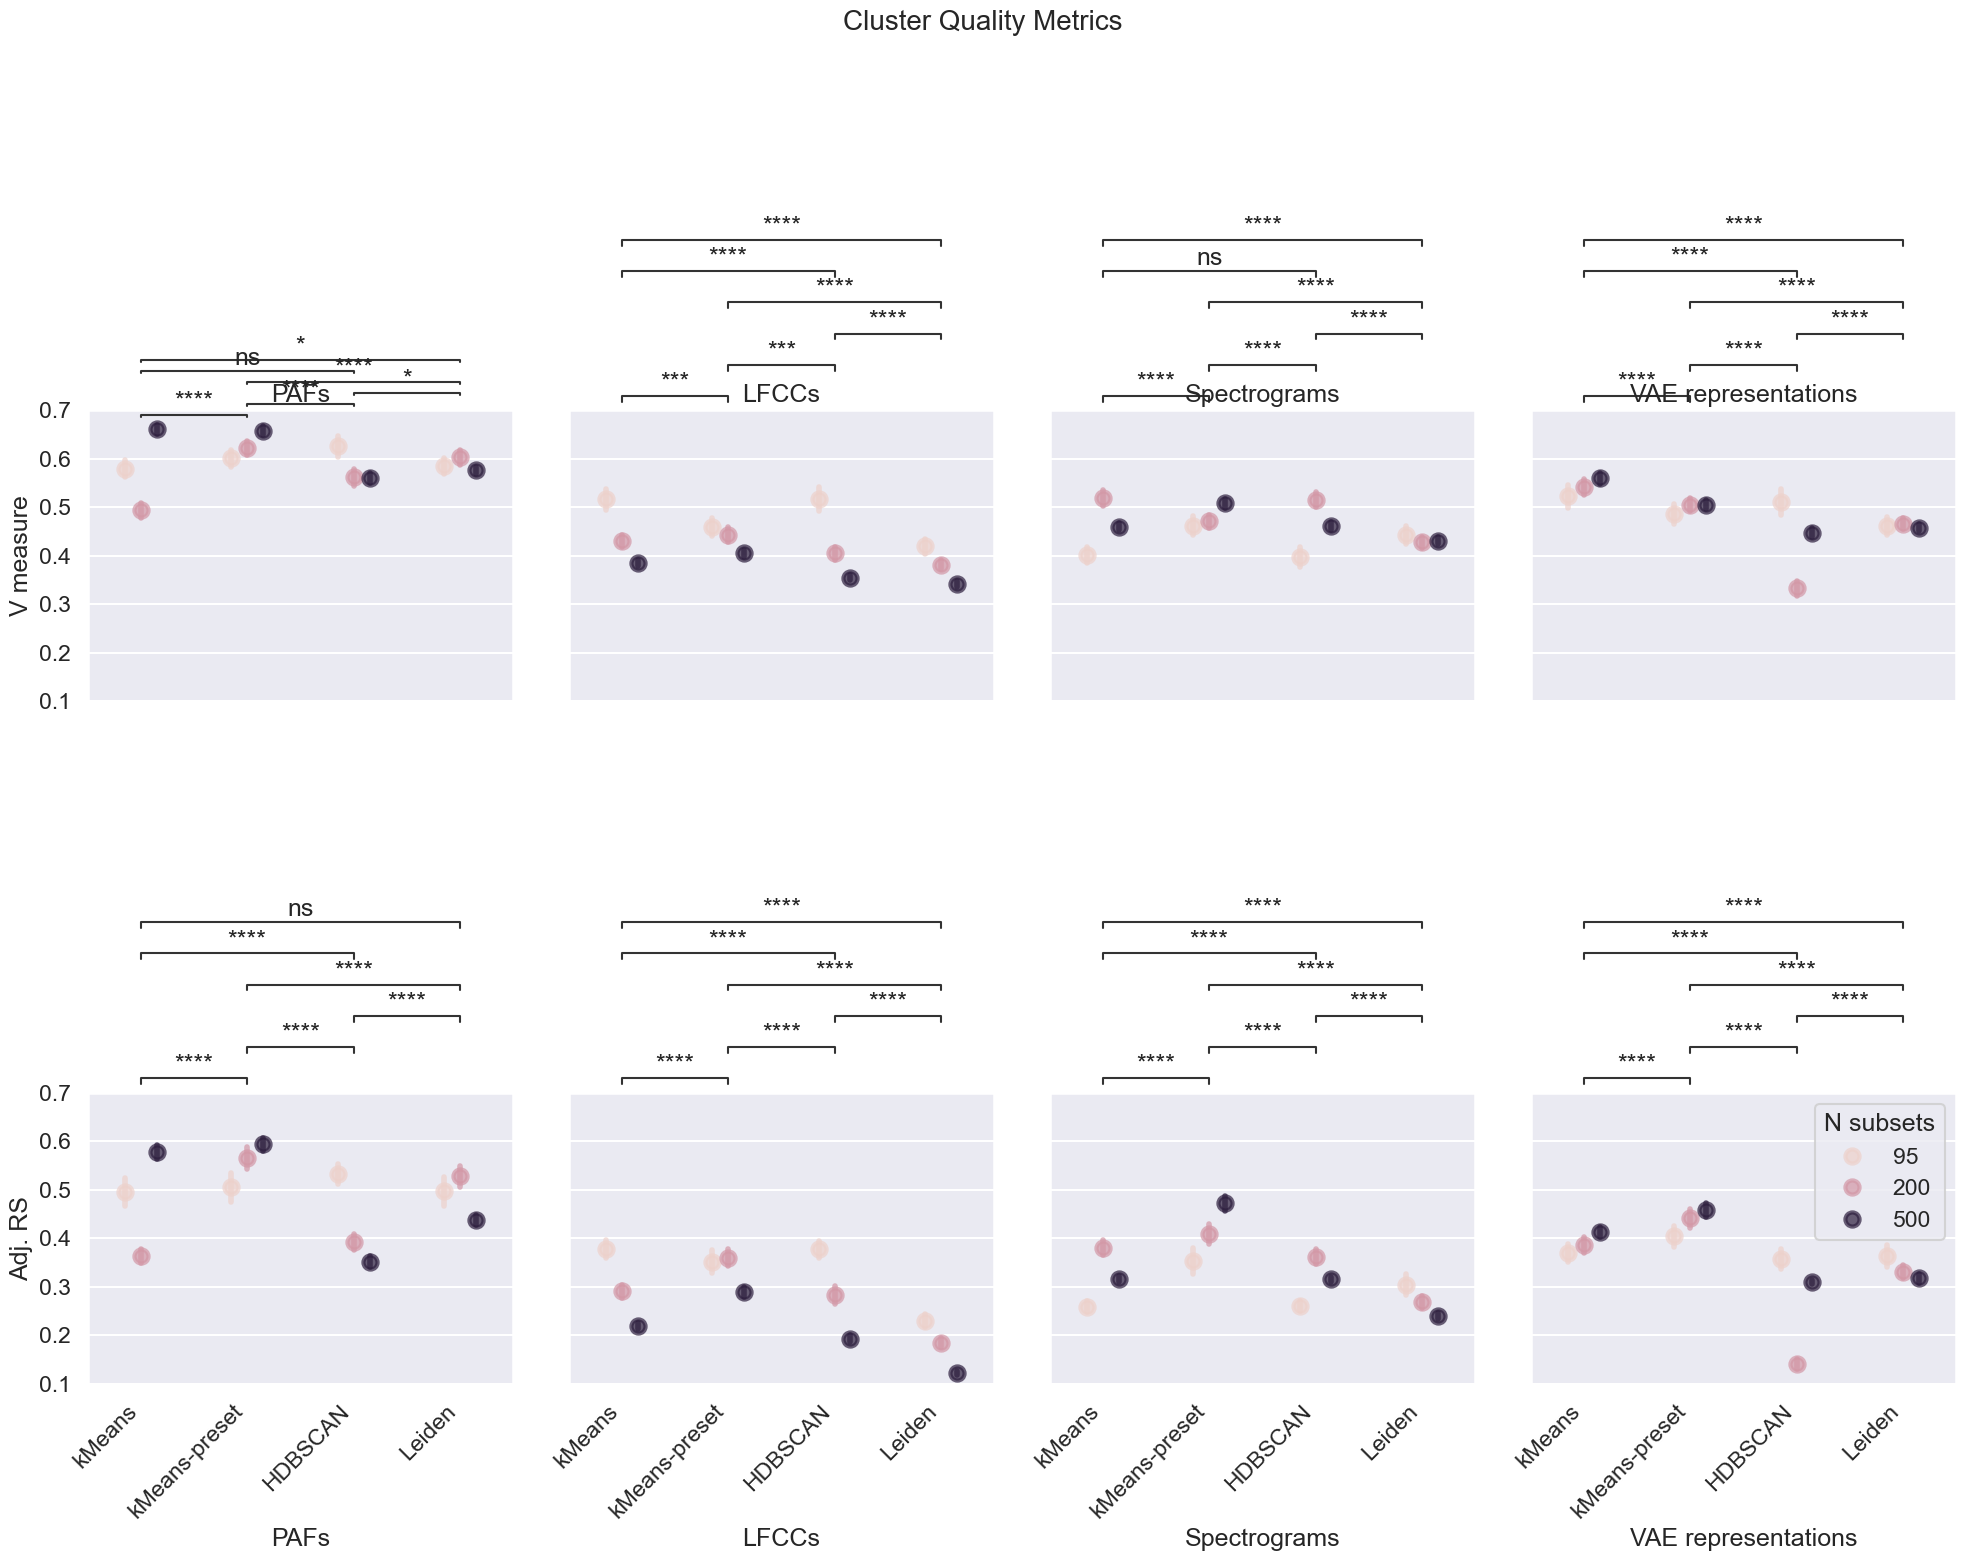

In [ ]:
rows = ["V measure", "Adj. RS"]
columns = ["PAFs", "LFCCs", "Spectrograms", "VAE representations"]
pairs = [("kMeans-preset", "kMeans"), 
       ("kMeans-preset", "HDBSCAN"), 
       ("kMeans-preset", "Leiden"), 
       ("kMeans", "HDBSCAN"), 
       ("kMeans", "Leiden"), 
       ("HDBSCAN", "Leiden")]

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 16), sharex=True, sharey=True)
for row, metric in enumerate(rows):
    for col, representation in enumerate(columns):
        data = true_vs_pred_df_exploded_filtered[true_vs_pred_df_exploded_filtered["Representation"] == representation]

        sns.pointplot(
            x="Algorithm", 
            y=metric,  
            data=data, 
            ax=axs[row, col], 
            hue="N subsets", 
            linestyle="none",
            alpha=.7,
            errorbar="sd",
            dodge=.3,
            legend=(True if row==1 and col==3 else False)
        )
        annotator = Annotator(axs[row, col], data=data, x="Algorithm", y=metric, pairs=pairs)
        annotator.configure(test='t-test_paired', text_format='star', loc='outside')
        annotator.apply_and_annotate()
        
        if row == 0:
            axs[row, col].set_title(representation)

        axs[row, col].set_ylim(0.1, 0.7)
        axs[row, col].set_xticklabels(algorithm_keys, rotation=45, ha='right')
        axs[row, col].set_xlabel(representation)

        if col == 0:
            axs[row, col].set_ylabel(metric)  # Label only the first column
        else:
            axs[row, col].set_ylabel('')

fig.suptitle("Cluster Quality Metrics", fontsize=20)
plt.tight_layout()
plt.show()

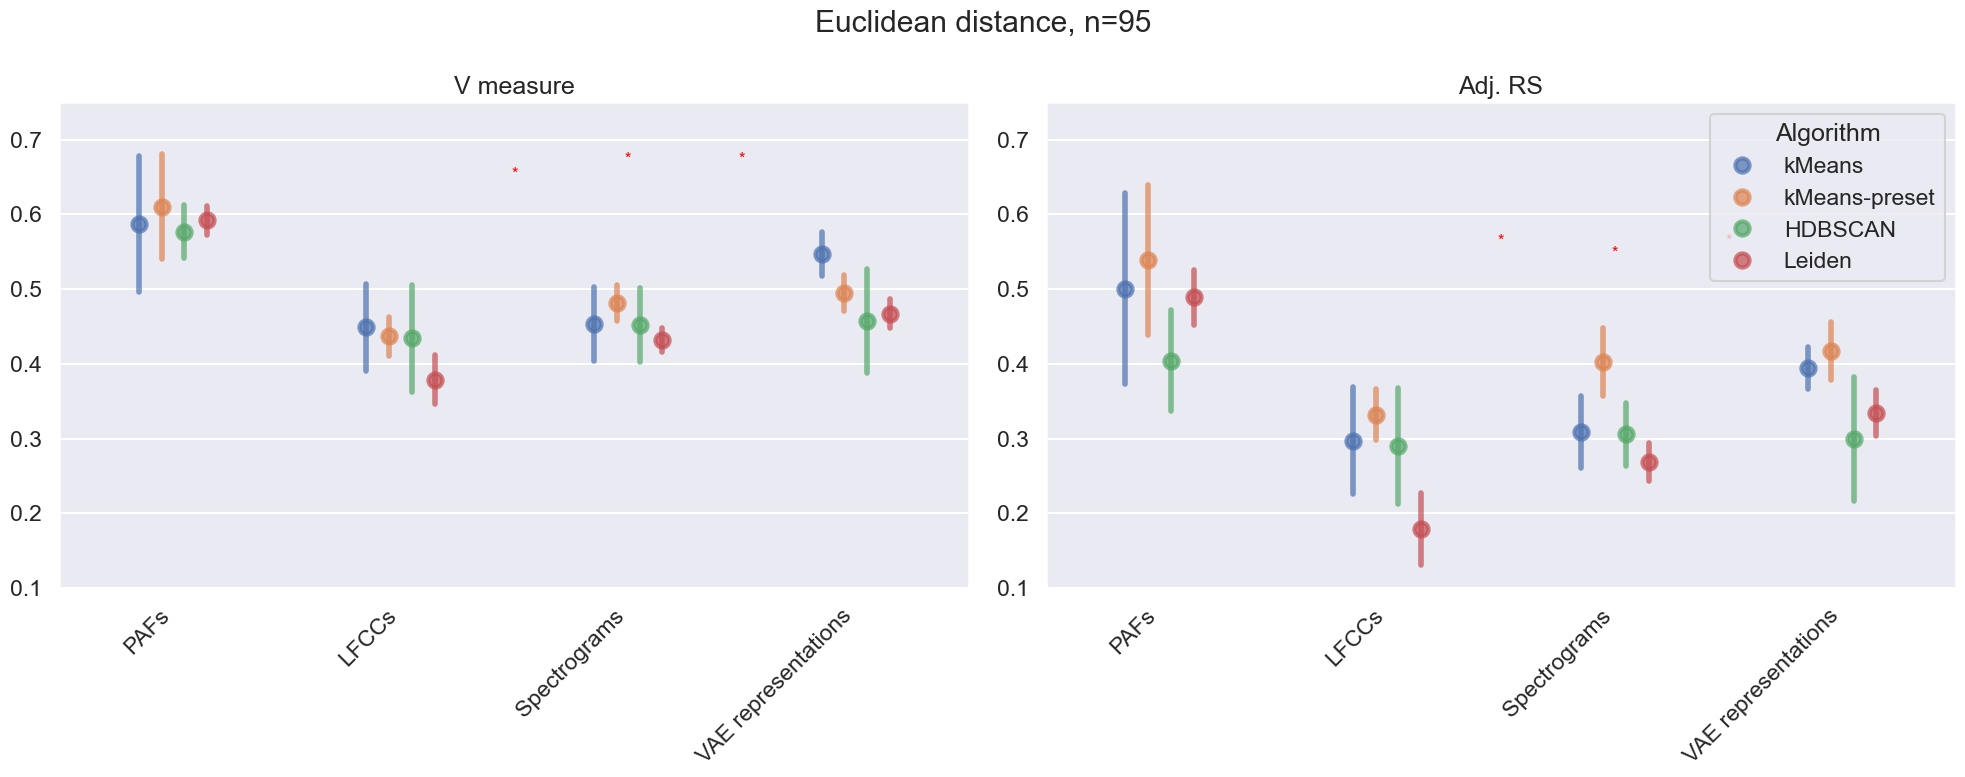

In [ ]:
def add_significance(ax, data, x, y, significance_level=0.05):
    representations = ['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations']
    
    # Loop over the representations to compare them
    for i, rep1 in enumerate(representations):
        for j, rep2 in enumerate(representations):
            if i >= j:
                continue
            
            # Get the data for the two representations
            group1 = data[data[x] == rep1][y]
            group2 = data[data[x] == rep2][y]
            
            # Perform t-test (or any other pairwise test)
            t_stat, p_value = ttest_rel(group1, group2)
            
            # If the p-value is below the significance level, add an asterisk
            if p_value < significance_level:
                # Annotate with asterisk at the mean y-value between the groups
                ax.annotate('*', 
                            xy=((i+j)/2, max(group1.max(), group2.max()) + 0.05),
                            ha='center', va='bottom', color='red', fontsize=12)

# Now create your plot using the dataframe directly
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

columns = ["V measure", "Adj. RS"]
for i, column in enumerate(columns):
    # Raw datapoints
    sns.pointplot(
        x="Representation", 
        y=column, 
        data=true_vs_pred_df_exploded, 
        ax=axs[i], 
        hue="Algorithm", 
        legend=(True if i == len(columns)-1 else False),
        linestyle="none",
        alpha=.7,
        errorbar="sd",
        dodge=.3,
    )
    
    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_ylim(0.1, .75)

    # Add significance asterisks directly from the dataframe
    add_significance(axs[i], true_vs_pred_df_exploded, 'Representation', column)

fig.suptitle("Euclidean distance, n=95")
plt.tight_layout()
plt.show()


In [26]:
# Create LaTeX table with bold p-values for significance
latex_table = "\\begin{table}[ht]\n"
latex_table += "\\centering\n"
latex_table += "\\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}\n"
latex_table += "\\hline\n"
latex_table += "N subsets & Distance metric & Alarm call subset & Representation & Algorithm A & Algorithm B & Adjusted Rand Score & \\textbf{Adjusted Rand Score p-value} & V Measure Score & \\textbf{V Measure Score p-value} \\\\ \n"
latex_table += "\\hline\n"

# Loop through the results and create the table rows
for idx, row in match_scores_across_results.iterrows():
    adj_rs_pvalue = row["Adjusted Rand Score - p-value"]
    v_measure_pvalue = row["V Measure Score - p-value"]
    
    # Bold p-value if significant
    adj_rs_pvalue_str = f"\\textbf{{{adj_rs_pvalue:.3f}}}" if adj_rs_pvalue < 0.05 else f"{adj_rs_pvalue:.3f}"
    v_measure_pvalue_str = f"\\textbf{{{v_measure_pvalue:.3f}}}" if v_measure_pvalue < 0.05 else f"{v_measure_pvalue:.3f}"
    
    latex_table += f"{row['N subsets']} & {row['Distance metric']} & {row['Alarm call subset']} & {row['Representation']} & {row['Algorithm A']} & {row['Algorithm B']} & {row['Adjusted Rand Score']:.3f} & {adj_rs_pvalue_str} & {row['V Measure Score']:.3f} & {v_measure_pvalue_str} \\\\ \n"
    latex_table += "\\hline\n"

latex_table += "\\end{tabular}\n"
latex_table += "\\caption{Statistical Comparison between Algorithm Pairs}\n"
latex_table += "\\end{table}"

# Output the LaTeX code
print(latex_table)


\begin{table}[ht]
\centering
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
N subsets & Distance metric & Alarm call subset & Representation & Algorithm A & Algorithm B & Adjusted Rand Score & \textbf{Adjusted Rand Score p-value} & V Measure Score & \textbf{V Measure Score p-value} \\ 
\hline
95 & l2 & yes & PAFs & kMeans & kMeans-preset & -2.440 & \textbf{0.016} & -8.538 & \textbf{0.000} \\ 
\hline
95 & l2 & yes & PAFs & kMeans & HDBSCAN & -10.446 & \textbf{0.000} & -15.632 & \textbf{0.000} \\ 
\hline
95 & l2 & yes & PAFs & kMeans & Leiden & -0.333 & 0.740 & -1.805 & 0.074 \\ 
\hline
95 & l2 & yes & PAFs & kMeans-preset & HDBSCAN & -6.740 & \textbf{0.000} & -8.805 & \textbf{0.000} \\ 
\hline
95 & l2 & yes & PAFs & kMeans-preset & Leiden & 1.996 & \textbf{0.049} & 7.975 & \textbf{0.000} \\ 
\hline
95 & l2 & yes & PAFs & HDBSCAN & Leiden & 9.504 & \textbf{0.000} & 15.037 & \textbf{0.000} \\ 
\hline
95 & l2 & yes & LFCCs & kMeans & kMeans-preset & 8.041 & \textbf{0.000} & 19.697 & \textbf

In [ ]:
algorithm_keys_wo_leiden = ["kMeans", "kMeans-preset", "HDBSCAN"]
rows = []
for di in dicts:
    for representation in representation_keys:
        for algorithm_a, algorithm_b in itertools.product(algorithm_keys_wo_leiden, algorithm_keys_wo_leiden):
            if algorithm_a == algorithm_b:
                continue
            krusk_res = stats.silhouette_across_embeddings(di[representation][algorithm_a], di[representation][algorithm_b], di[representation]["embeddings"])
            rows.append([
                di["n"], 
                di["distance_metric"], 
                di["alarm"],
                representation, 
                algorithm_a, 
                algorithm_b,
                krusk_res.statistic, 
                krusk_res.pvalue,
                ])

silhouette_scores_across_results = pd.DataFrame(
    rows, 
    columns=["N subsets", "Distance metric", "Alarm call subset", "Representation", "Algorithm a", "Algorithm b", 
             "Silhouette score - Kruskal statistic", "Silhouette score - Kruskal p-value",]
)

silhouette_scores_across_results

,N subsets,Distance metric,Alarm call subset,Representation,Algorithm a,Algorithm b,Silhouette score - Kruskal statistic,Silhouette score - Kruskal p-value
0,95,l2,yes,PAFs,kMeans,kMeans-preset,0.861517,0.353315
1,95,l2,yes,PAFs,kMeans,HDBSCAN,15.838977,0.000069
2,95,l2,yes,PAFs,kMeans-preset,kMeans,0.861517,0.353315
3,95,l2,yes,PAFs,kMeans-preset,HDBSCAN,16.577256,0.000047
4,95,l2,yes,PAFs,HDBSCAN,kMeans,15.838977,0.000069
...,...,...,...,...,...,...,...,...
115,500,l2,no,VAE representations,kMeans,HDBSCAN,0.085212,0.770355
116,500,l2,no,VAE representations,kMeans-preset,kMeans,2621.646610,0.000000
117,500,l2,no,VAE representations,kMeans-preset,HDBSCAN,2260.734439,0.000000
118,500,l2,no,VAE representations,HDBSCAN,kMeans,0.085212,0.770355


In [ ]:
# Generate LaTeX Table
latex_table_2 = silhouette_scores_across_results.to_latex(
    index=True,
    multirow=True,
    caption="Clustering Metrics for Representations",
    label="tab:clustering_metrics",
    na_rep="---",
)

print(latex_table_2)

\begin{table}
\caption{Clustering Metrics for Representations}
\label{tab:clustering_metrics}
\begin{tabular}{lrlllllrr}
\toprule
 & N subsets & Distance metric & Alarm call subset & Representation & Algorithm a & Algorithm b & Silhouette score - Kruskal statistic & Silhouette score - Kruskal p-value \\
\midrule
0 & 95 & l2 & yes & PAFs & kMeans & kMeans-preset & 0.861517 & 0.353315 \\
1 & 95 & l2 & yes & PAFs & kMeans & HDBSCAN & 15.838977 & 0.000069 \\
2 & 95 & l2 & yes & PAFs & kMeans-preset & kMeans & 0.861517 & 0.353315 \\
3 & 95 & l2 & yes & PAFs & kMeans-preset & HDBSCAN & 16.577256 & 0.000047 \\
4 & 95 & l2 & yes & PAFs & HDBSCAN & kMeans & 15.838977 & 0.000069 \\
5 & 95 & l2 & yes & PAFs & HDBSCAN & kMeans-preset & 16.577256 & 0.000047 \\
6 & 95 & l2 & yes & LFCCs & kMeans & kMeans-preset & 19.397055 & 0.000011 \\
7 & 95 & l2 & yes & LFCCs & kMeans & HDBSCAN & 0.000000 & 1.000000 \\
8 & 95 & l2 & yes & LFCCs & kMeans-preset & kMeans & 19.397055 & 0.000011 \\
9 & 95 & l2 & yes 

In [29]:
# https://github.com/timsainb/avgn_paper/blob/63e25ca535a230f96b7fb1017728ead6ee0bf36b/notebooks/06.0-neural-networks/starling_figs/Starling-VAE2-128.ipynb
# https://github.com/timsainb/avgn_paper/blob/63e25ca535a230f96b7fb1017728ead6ee0bf36b/avgn/tensorflow/VAE2.py
# vae

In [30]:
# https://github.com/timsainb/avgn_paper/blob/63e25ca535a230f96b7fb1017728ead6ee0bf36b/notebooks/09.0-clusterability/make-clusterability-plot-convex-hull-indvs-final.ipynb
# hopkins

In [31]:
# https://github.com/timsainb/avgn_paper/blob/63e25ca535a230f96b7fb1017728ead6ee0bf36b/notebooks/04.0-clusters-vs-labels-metrics/BF-koumura-cluster-label-performance.ipynb
# v measure

## print results to latex table

In [32]:
# # Generate LaTeX Table
# latex_table = df_for_latex.to_latex(
#     index=True,
#     multirow=True,
#     caption="Clustering Metrics for Representations",
#     label="tab:clustering_metrics",
#     na_rep="---",
# )

# print(latex_table.replace("[t]{4}{*}", ""))

### GLM

In [ ]:
data_encoded = pd.get_dummies(true_vs_pred_df[true_vs_pred_df["Alarm call subset"]=="yes"], columns=['N subsets', 'Distance metric', 'Algorithm', 'Representation'], drop_first=True)

data_encoded["V measure"] = np.mean(data_encoded["V measure"].values[0])
data_encoded["Adj. RS"] = np.mean(data_encoded["Adj. RS"].values[0])
data_encoded["Homogeneity"] = np.mean(data_encoded["Homogeneity"].values[0])
data_encoded["Completeness"] = np.mean(data_encoded["Completeness"].values[0])

data_encoded = data_encoded.drop(columns=["p-value", "Chance level", "Alarm call subset"])

# Convert boolean columns to integers
data_encoded = data_encoded.astype(float)

print(data_encoded.dtypes)
data_encoded

V measure                             float64
Homogeneity                           float64
Completeness                          float64
Adj. RS                               float64
N subsets_200                         float64
N subsets_500                         float64
Distance metric_l2                    float64
Algorithm_Leiden                      float64
Algorithm_kMeans                      float64
Algorithm_kMeans-preset               float64
Representation_PAFs                   float64
Representation_Spectrograms           float64
Representation_VAE representations    float64
dtype: object


,V measure,Homogeneity,Completeness,Adj. RS,N subsets_200,N subsets_500,Distance metric_l2,Algorithm_Leiden,Algorithm_kMeans,Algorithm_kMeans-preset,Representation_PAFs,Representation_Spectrograms,Representation_VAE representations
0,0.580042,0.599461,0.556452,0.495235,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.580042,0.599461,0.556452,0.495235,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.580042,0.599461,0.556452,0.495235,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.580042,0.599461,0.556452,0.495235,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.580042,0.599461,0.556452,0.495235,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.580042,0.599461,0.556452,0.495235,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
60,0.580042,0.599461,0.556452,0.495235,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
61,0.580042,0.599461,0.556452,0.495235,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
62,0.580042,0.599461,0.556452,0.495235,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
import statsmodels.api as sm

# Define predictors (independent variables) and target variable
X = data_encoded.drop(columns=['V measure', 'Homogeneity', 'Completeness', 'Adj. RS'])

# Add intercept term
X = sm.add_constant(X)

y = data_encoded['V measure']
glm_V = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(glm_V.summary())

y = data_encoded['Adj. RS']
glm_RS = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(glm_RS.summary())

y = data_encoded['Homogeneity']
glm_H = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(glm_H.summary())

y = data_encoded['Completeness']
glm_C = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(glm_C.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              V measure   No. Observations:                   64
Model:                            GLM   Df Residuals:                       54
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28.461
Date:                Tue, 11 Feb 2025   Deviance:                  -5.9568e-15
Time:                        20:01:08   Pearson chi2:                 7.91e-29
No. Iterations:                     3   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:134

In [35]:
from sklearn.preprocessing import LabelEncoder

# Filter data
data = true_vs_pred_df[true_vs_pred_df["Alarm call subset"] == "yes"].copy()

# Initialize encoders separately for each categorical column
label_encoder_rep = LabelEncoder()
label_encoder_alg = LabelEncoder()
label_encoder_dist = LabelEncoder()

# label encoding
data["Representation"] = label_encoder_rep.fit_transform(data["Representation"])
data["Algorithm"] = label_encoder_alg.fit_transform(data["Algorithm"])
data["Distance metric"] = label_encoder_dist.fit_transform(data["Distance metric"])

# mean values for metrics
data["V measure"] = np.mean(data["V measure"].values[0])
data["Adj. RS"] = np.mean(data["Adj. RS"].values[0])
data["Homogeneity"] = np.mean(data["Homogeneity"].values[0])
data["Completeness"] = np.mean(data["Completeness"].values[0])

# Drop unnecessary columns
data = data.drop(columns=["p-value", "Chance level", "Alarm call subset"])

# Convert boolean columns to float
data = data.astype(float)

# Store label mappings
label_mappings = {
    "Representation": dict(zip(label_encoder_rep.classes_, label_encoder_rep.transform(label_encoder_rep.classes_))),
    "Algorithm": dict(zip(label_encoder_alg.classes_, label_encoder_alg.transform(label_encoder_alg.classes_))),
    "Distance metric": dict(zip(label_encoder_dist.classes_, label_encoder_dist.transform(label_encoder_dist.classes_)))
}


print(label_mappings)
data

{'Representation': {'LFCCs': 0, 'PAFs': 1, 'Spectrograms': 2, 'VAE representations': 3}, 'Algorithm': {'HDBSCAN': 0, 'Leiden': 1, 'kMeans': 2, 'kMeans-preset': 3}, 'Distance metric': {'l1': 0, 'l2': 1}}


,N subsets,Distance metric,Representation,Algorithm,V measure,Homogeneity,Completeness,Adj. RS
0,95.0,1.0,1.0,2.0,0.580042,0.599461,0.556452,0.495235
1,95.0,1.0,1.0,3.0,0.580042,0.599461,0.556452,0.495235
2,95.0,1.0,1.0,0.0,0.580042,0.599461,0.556452,0.495235
3,95.0,1.0,1.0,1.0,0.580042,0.599461,0.556452,0.495235
4,95.0,1.0,0.0,2.0,0.580042,0.599461,0.556452,0.495235
...,...,...,...,...,...,...,...,...
59,500.0,1.0,2.0,1.0,0.580042,0.599461,0.556452,0.495235
60,500.0,1.0,3.0,2.0,0.580042,0.599461,0.556452,0.495235
61,500.0,1.0,3.0,3.0,0.580042,0.599461,0.556452,0.495235
62,500.0,1.0,3.0,0.0,0.580042,0.599461,0.556452,0.495235


In [ ]:
# Define predictors (independent variables) and target variable
X = data.drop(columns=['V measure', 'Homogeneity', 'Completeness', 'Adj. RS'])

# Add intercept term
X = sm.add_constant(X)

y = data['V measure']
glm_V = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(glm_V.summary())

y = data['Adj. RS']
glm_RS = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(glm_RS.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              V measure   No. Observations:                   64
Model:                            GLM   Df Residuals:                       59
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28.461
Date:                Tue, 11 Feb 2025   Deviance:                   4.6386e-15
Time:                        20:01:09   Pearson chi2:                 1.02e-27
No. Iterations:                     3   Pseudo R-squ. (CS):          1.110e-16
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3229      0.717     

/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


In [37]:
# Define predictors (independent variables) and target variable
X = data.drop(columns=['V measure', 'Homogeneity', 'Completeness', 'Adj. RS'])

# Add intercept term
X = sm.add_constant(X)

y = data['V measure']
glm_V = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(glm_V.summary())

y = data['Adj. RS']
glm_RS = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(glm_RS.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              V measure   No. Observations:                   64
Model:                            GLM   Df Residuals:                       59
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28.461
Date:                Tue, 11 Feb 2025   Deviance:                   4.6386e-15
Time:                        20:01:09   Pearson chi2:                 1.02e-27
No. Iterations:                     3   Pseudo R-squ. (CS):          1.110e-16
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3229      0.717     

/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


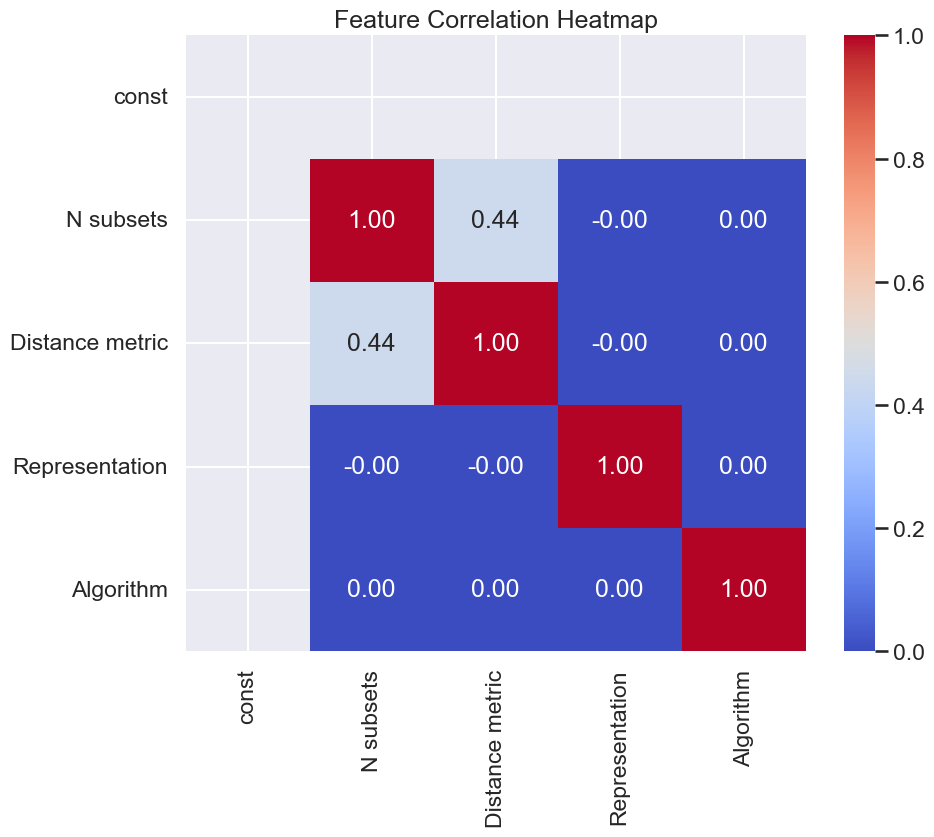

In [ ]:
corr_matrix = X.corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# Filter data
data = true_vs_pred_df.copy()

# Initialize encoders separately for each categorical column
label_encoder_rep = LabelEncoder()
label_encoder_alg = LabelEncoder()
label_encoder_dist = LabelEncoder()
label_encoder_alarm = LabelEncoder()

# label encoding
data["Representation"] = label_encoder_rep.fit_transform(data["Representation"])
data["Algorithm"] = label_encoder_alg.fit_transform(data["Algorithm"])
data["Distance metric"] = label_encoder_dist.fit_transform(data["Distance metric"])
data["Alarm call subset"] = label_encoder_alarm.fit_transform(data["Alarm call subset"])

# Drop unnecessary columns
data = data.drop(columns=["p-value", "Chance level"])

# explode metric columns
data_exploded = data.explode(["Homogeneity", "Completeness", "V measure", "Adj. RS"], ignore_index=True)

# Convert boolean columns to float
data_exploded = data_exploded.astype(float)

# Store label mappings
label_mappings = {
    "Representation": dict(zip(label_encoder_rep.classes_, label_encoder_rep.transform(label_encoder_rep.classes_))),
    "Algorithm": dict(zip(label_encoder_alg.classes_, label_encoder_alg.transform(label_encoder_alg.classes_))),
    "Distance metric": dict(zip(label_encoder_dist.classes_, label_encoder_dist.transform(label_encoder_dist.classes_)))
}

print(label_mappings)
data_exploded

{'Representation': {'LFCCs': 0, 'PAFs': 1, 'Spectrograms': 2, 'VAE representations': 3}, 'Algorithm': {'HDBSCAN': 0, 'Leiden': 1, 'kMeans': 2, 'kMeans-preset': 3}, 'Distance metric': {'l1': 0, 'l2': 1}}


,N subsets,Distance metric,Alarm call subset,Representation,Algorithm,V measure,Homogeneity,Completeness,Adj. RS
0,95.0,1.0,1.0,1.0,2.0,0.563787,0.604585,0.550804,0.495253
1,95.0,1.0,1.0,1.0,2.0,0.565966,0.601661,0.576099,0.520054
2,95.0,1.0,1.0,1.0,2.0,0.562972,0.618932,0.561254,0.497328
3,95.0,1.0,1.0,1.0,2.0,0.571507,0.591624,0.566474,0.499577
4,95.0,1.0,1.0,1.0,2.0,0.577495,0.569291,0.547797,0.498938
...,...,...,...,...,...,...,...,...,...
7995,500.0,1.0,0.0,3.0,1.0,0.501973,0.554670,0.432477,0.372367
7996,500.0,1.0,0.0,3.0,1.0,0.488976,0.557458,0.447861,0.366062
7997,500.0,1.0,0.0,3.0,1.0,0.491448,0.552560,0.467129,0.374208
7998,500.0,1.0,0.0,3.0,1.0,0.501701,0.547244,0.455696,0.371244


In [43]:
# Define predictors (independent variables) and target variable
X = data_exploded.drop(columns=['V measure', 'Homogeneity', 'Completeness', 'Adj. RS'])

# Add intercept term
X = sm.add_constant(X)

y = data_exploded['V measure']
glm_V = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(glm_V.summary())

y = data_exploded['Adj. RS']
glm_RS = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(glm_RS.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              V measure   No. Observations:                 8000
Model:                            GLM   Df Residuals:                     7995
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3659.2
Date:                Wed, 12 Feb 2025   Deviance:                       214.80
Time:                        14:41:21   Pearson chi2:                     212.
No. Iterations:                     3   Pseudo R-squ. (CS):           0.001108
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.2071      0.067     

In [ ]:
# Define predictors (independent variables) and target variable
X = data_exploded.drop(columns=['V measure', 'Homogeneity', 'Completeness', 'Adj. RS'])

# Add intercept term
X = sm.add_constant(X)

y = data_exploded['V measure']
glm_V = sm.GLM(y, X, family=sm.families.Gamma()).fit()
print(glm_V.summary())

y = data_exploded['Adj. RS']
glm_RS = sm.GLM(y, X, family=sm.families.Gamma()).fit()
print(glm_RS.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              V measure   No. Observations:                 8000
Model:                            GLM   Df Residuals:                     7995
Model Family:                   Gamma   Df Model:                            4
Link Function:           InversePower   Scale:                        0.027775
Method:                          IRLS   Log-Likelihood:                 8855.1
Date:                Wed, 12 Feb 2025   Deviance:                       217.72
Time:                        14:45:24   Pearson chi2:                     222.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.04067
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.2175      0.012    1

/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [ ]:
import statsmodels.formula.api as smf

data_exploded.rename(columns={'Distance metric': 'Distance_metric', 'N subsets': 'N_subsets', 'V measure': 'V_measure', 'Adj. RS': 'Adj_RS', 'Alarm call subset': 'Alarm_call_subset'}, inplace=True)

formula = "V_measure ~ Distance_metric + C(Representation) + C(Algorithm) + N_subsets + Alarm_call_subset"
glm_beta = smf.glm(formula, data=data_exploded,
                    family=sm.families.Binomial(link=sm.families.links.logit())).fit()
# glm_beta = sm.GLM(y, X, family=sm.families.Binomial(link=sm.families.links.logit())).fit()
print(glm_beta.summary())

formula = "Adj_RS ~ Distance_metric + C(Representation) + C(Algorithm) + N_subsets + Alarm_call_subset"
glm_beta = smf.glm(formula, data=data_exploded,
                    family=sm.families.Binomial(link=sm.families.links.logit())).fit()
# glm_beta = sm.GLM(y, X, family=sm.families.Binomial(link=sm.families.links.logit())).fit()
print(glm_beta.summary())
print(label_mappings)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              V_measure   No. Observations:                 8000
Model:                            GLM   Df Residuals:                     7990
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3593.2
Date:                Wed, 12 Feb 2025   Deviance:                       82.878
Time:                        15:11:05   Pearson chi2:                     82.8
No. Iterations:                     3   Pseudo R-squ. (CS):            0.01744
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(
